In [82]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point, Polygon, LineString, MultiPolygon
from shapely.ops import unary_union
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import rasterio
import rasterstats
from rasterio.plot import show
from rasterio.plot import show_hist
import osmnx as ox
import folium
import requests

In [83]:
pd.options.display.max_columns = 150

# Dependent Variable

## PLACEs data processing

PLACES reports county-, place-, census tract-, and ZCTA-level data and uses small area estimation methods to obtain 29 (27 in the 2020 release) chronic disease measures for the entire United States. PLACE 2021 version mearsures 2019 and 2018 health related data

**Detail Information:** https://www.cdc.gov/places/

**Source:** https://chronicdata.cdc.gov/500-Cities-Places/PLACES-Local-Data-for-Better-Health-Census-Tract-D/cwsq-ngmh

**Geography:** Census Tract

**Date:** 2019 (release December 1, 2021)

In [84]:
# read cdc PLACEs health data
PLACEs = pd.read_csv('./Data/Raw_Data/PLACES__Local_Data_for_Better_Health__Census_Tract_Data_2021_release.csv'
                    ,usecols=['Year','StateAbbr','CountyName','Category','Measure','Data_Value','TotalPopulation','Geolocation','LocationID','MeasureId','CategoryID']
                    )
PLACEs.head()

,Year,StateAbbr,CountyName,Category,Measure,Data_Value,TotalPopulation,Geolocation,LocationID,CategoryID,MeasureId
0,2019,AR,Craighead,Health Outcomes,Stroke among adults aged >=18 years,3.5,6516,POINT (-90.71822092 35.81904551),5031000300,HLTHOUT,STROKE
1,2019,AR,Craighead,Health Outcomes,Depression among adults aged >=18 years,26.2,6139,POINT (-90.61608228 35.87373244),5031000501,HLTHOUT,DEPRESSION
2,2019,CA,Alameda,Health Outcomes,Stroke among adults aged >=18 years,7.4,2788,POINT (-122.2706945 37.80052483),6001403000,HLTHOUT,STROKE
3,2019,CA,Alameda,Health Outcomes,Obesity among adults aged >=18 years,26.3,2238,POINT (-122.2754581 37.80233855),6001403100,HLTHOUT,OBESITY
4,2019,CA,Alameda,Health Outcomes,Arthritis among adults aged >=18 years,15.8,2819,POINT (-122.2536907 37.82326962),6001404000,HLTHOUT,ARTHRITIS


In [85]:
# select data in NYC
PLACEsNY = PLACEs[PLACEs['StateAbbr'] == 'NY']
PLACEsNY = PLACEsNY[PLACEsNY['CountyName'].isin(['Bronx','Kings','New York','Queens','Richmond'])]
PLACEsNY.head()

,Year,StateAbbr,CountyName,Category,Measure,Data_Value,TotalPopulation,Geolocation,LocationID,CategoryID,MeasureId
1240910,2019,NY,Bronx,Health Risk Behaviors,No leisure-time physical activity among adults...,34.9,1907,POINT (-73.9128415 40.81821599),36005007100,RISKBEH,LPA
1240911,2019,NY,Bronx,Health Outcomes,Diagnosed diabetes among adults aged >=18 years,15.7,2303,POINT (-73.85902728 40.87309199),36005037000,HLTHOUT,DIABETES
1240914,2018,NY,Bronx,Prevention,"Fecal occult blood test, sigmoidoscopy, or col...",43.6,11091,POINT (-73.88265696 40.7911001),36005000100,PREVENT,COLON_SCREEN
1240916,2018,NY,Bronx,Prevention,Older adult men aged >=65 years who are up to ...,24.1,3598,POINT (-73.83457776 40.88631153),36005048400,PREVENT,COREM
1240918,2019,NY,Bronx,Health Outcomes,Cancer (excluding skin cancer) among adults ag...,4.0,1699,POINT (-73.91326373 40.84449183),36005022702,HLTHOUT,CANCER


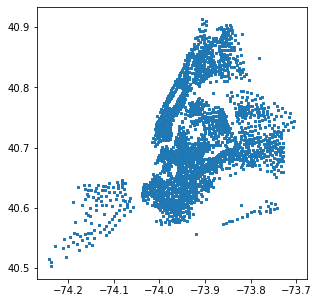

In [86]:
# take a look at the spatial distribution of health data
a = PLACEsNY.copy()
a['Geolocation'] = a['Geolocation'].apply(wkt.loads)
a = gpd.GeoDataFrame(a,geometry=a['Geolocation'],crs=4326)
a.plot(markersize=1, figsize=(5,5))
plt.show()

### sjoin with ct2010 census tract boundary 
### (Although the latest file is ct2020, consider for compatibility with all data location id, we use ct2010)

In [87]:
ct2010 = gpd.read_file('./Data/Raw_Data/Geo/2010_Census_Tracts/geo_export_56c76d30-fb47-4fa6-839d-06b327544523.shp')
ct2010.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
2,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
3,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."
4,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,"POLYGON ((-73.98412 40.75484, -73.98460 40.754..."


In [88]:
# check null value
ct2010.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   boro_code   2165 non-null   object  
 1   boro_ct201  2165 non-null   object  
 2   boro_name   2165 non-null   object  
 3   cdeligibil  2164 non-null   object  
 4   ct2010      2165 non-null   object  
 5   ctlabel     2165 non-null   object  
 6   ntacode     2165 non-null   object  
 7   ntaname     2165 non-null   object  
 8   puma        2165 non-null   object  
 9   shape_area  2165 non-null   float64 
 10  shape_leng  2165 non-null   float64 
 11  geometry    2165 non-null   geometry
dtypes: float64(2), geometry(1), object(9)
memory usage: 203.1+ KB


In [89]:
# check duplicate
ct2010[ct2010.duplicated()]

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry


In [90]:
# crate ct2010 GeoID for match PLACEs data

ct2010['GeoID']=0
for i in range(len(ct2010['boro_name'])):
    if (ct2010['boro_name'][i]=='Manhattan'):
        ct2010['GeoID'][i] = '36061'+ ct2010['ct2010'][i]
    
    elif (ct2010['boro_name'][i]=='Bronx'):
        ct2010['GeoID'][i] = '36005'+ ct2010['ct2010'][i]
        
    elif (ct2010['boro_name'][i]=='Queens'):
        ct2010['GeoID'][i] = '36081'+ ct2010['ct2010'][i]
    
    elif (ct2010['boro_name'][i]=='Brooklyn'):
        ct2010['GeoID'][i] = '36047'+ ct2010['ct2010'][i]
    
    elif (ct2010['boro_name'][i]=='Staten Island'):
        ct2010['GeoID'][i] = '36085'+ ct2010['ct2010'][i]
    
    else:
        print('no')

ct2010.head()  

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import ke

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,GeoID
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643...",36085000900
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,"POLYGON ((-73.96433 40.75638, -73.96479 40.755...",36061009800
2,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760...",36061010200
3,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761...",36061010400
4,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,"POLYGON ((-73.98412 40.75484, -73.98460 40.754...",36061011300


In [91]:
# save this geo file
ct2010.to_file('./Data/Processed_Data/ct2010_geoid.geojson', driver='GeoJSON')

In [92]:
len(PLACEsNY)

63498

In [93]:
# health data merge with ct2010 
PLACEsNY_Geo = pd.merge(PLACEsNY, ct2010, left_on='LocationID', right_on='GeoID')
PLACEsNY_Geo = gpd.GeoDataFrame(PLACEsNY_Geo, geometry=PLACEsNY_Geo['geometry'],crs={'init':'epsg:4326'})
len(PLACEsNY_Geo)

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


63498

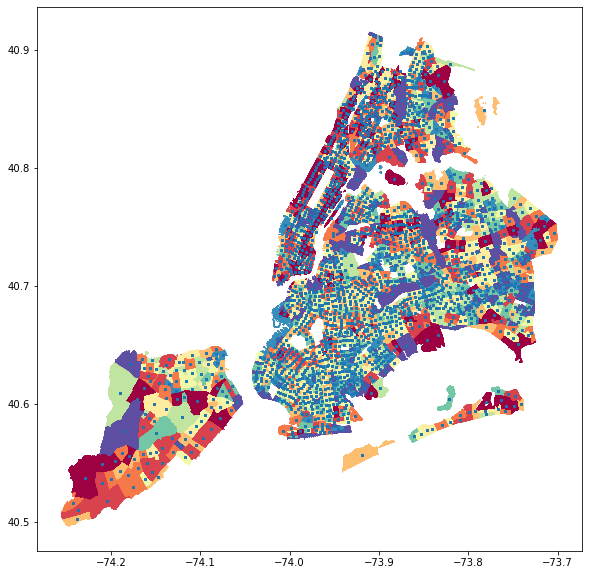

In [94]:
# take a look at if these two data sets merge well
base = PLACEsNY_Geo.plot(column='TotalPopulation', cmap='Spectral_r', 
                              legend=False, scheme='Quantiles', k=10,
                              figsize=(10,10))

a.plot(ax=base, markersize=1, figsize=(10,10));
plt.show()

### Fillter out the census tracts which population lower than 1000
The disease rate of a small number of people in a census tract is scarcely typical of the overall condition; for example, if there are only ten persons in a region and five of them are obese, the obesity rate is 50%, which is clearly unacceptably high.

In [95]:
PLACEsNY_clean_Geo = PLACEsNY_Geo[PLACEsNY_Geo['TotalPopulation'] >= 1000]
len(PLACEsNY_clean_Geo)                            

62550

Check if the county name of PLACE can be matched with the county name of ct2010.

In [96]:
PLACEsNY_clean_Geo.CountyName.unique()

array(['Bronx', 'Kings', 'New York', 'Queens', 'Richmond'], dtype=object)

In [97]:
PLACEsNY_clean_Geo.boro_name.unique()

array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object)

In [98]:
print(len(PLACEsNY_clean_Geo[(PLACEsNY_clean_Geo['CountyName'] == 'Bronx')\
                       & (PLACEsNY_clean_Geo['boro_name'] != 'Bronx')]))

print(len(PLACEsNY_clean_Geo[(PLACEsNY_clean_Geo['CountyName'] == 'Kings')\
                       & (PLACEsNY_clean_Geo['boro_name'] != 'Brooklyn')]))

print(len(PLACEsNY_clean_Geo[(PLACEsNY_clean_Geo['CountyName'] == 'New York')\
                       & (PLACEsNY_clean_Geo['boro_name'] != 'Manhattan')]))

print(len(PLACEsNY_clean_Geo[(PLACEsNY_clean_Geo['CountyName'] == 'Queens')\
                       & (PLACEsNY_clean_Geo['boro_name'] != 'Queens')]))

print(len(PLACEsNY_clean_Geo[(PLACEsNY_clean_Geo['CountyName'] == 'Richmond')\
                       & (PLACEsNY_clean_Geo['boro_name'] != 'Staten Island')]))

0
0
0
0
0


In [99]:
PLACEsNY_clean_Geo = PLACEsNY_clean_Geo.drop(['CountyName','boro_code','boro_ct201','cdeligibil','ctlabel','puma','LocationID','Geolocation'],axis=1)
PLACEsNY_clean_Geo.head()

,Year,StateAbbr,Category,Measure,Data_Value,TotalPopulation,CategoryID,MeasureId,boro_name,ct2010,ntacode,ntaname,shape_area,shape_leng,geometry,GeoID
0,2019,NY,Health Risk Behaviors,No leisure-time physical activity among adults...,34.9,1907,RISKBEH,LPA,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.54257,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100
1,2019,NY,Prevention,Current lack of health insurance among adults ...,23.3,1907,PREVENT,ACCESS2,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.54257,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100
2,2018,NY,Health Risk Behaviors,Sleeping less than 7 hours among adults aged >...,41.1,1907,RISKBEH,SLEEP,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.54257,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100
3,2019,NY,Health Outcomes,Cancer (excluding skin cancer) among adults ag...,4.7,1907,HLTHOUT,CANCER,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.54257,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100
4,2019,NY,Health Outcomes,Stroke among adults aged >=18 years,3.3,1907,HLTHOUT,STROKE,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.54257,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100


In [100]:
PLACEsNY_clean_Geo.describe()

,Year,Data_Value,TotalPopulation,shape_area,shape_leng,GeoID
count,62550.000000,62550.000000,62550.000000,6.255000e+04,62550.000000,6.255000e+04
mean,2018.733333,30.613741,3914.597602,3.380277e+06,8136.093759,3.605460e+10
std,0.442220,27.018180,2094.765579,5.167626e+06,5589.593829,2.595758e+07
min,2018.000000,0.600000,1003.000000,4.478077e+05,2816.869528,3.600500e+10
25%,2018.000000,11.100000,2397.000000,1.677792e+06,5602.246872,3.604702e+10
50%,2019.000000,19.300000,3507.000000,1.969158e+06,6467.648368,3.604712e+10
75%,2019.000000,42.400000,4917.000000,2.949066e+06,8457.521157,3.608103e+10
max,2019.000000,97.300000,26588.000000,1.057417e+08,93905.197358,3.608503e+10


In [101]:
#save file
PLACEsNY_clean_Geo.to_file('./Data/Processed_Data/PLACEsNY_clean_Geo.geojson', driver='GeoJSON')

### Separate Health Status and Health Outcomes

In [102]:
PLACEsNY_clean_Geo.Category.unique()

array(['Health Risk Behaviors', 'Prevention', 'Health Outcomes',
       'Health Status'], dtype=object)

In [103]:
HStatus = PLACEsNY_clean_Geo[PLACEsNY_clean_Geo['Category'] == 'Health Status']
HOutcomes = PLACEsNY_clean_Geo[PLACEsNY_clean_Geo['Category'] == 'Health Outcomes']

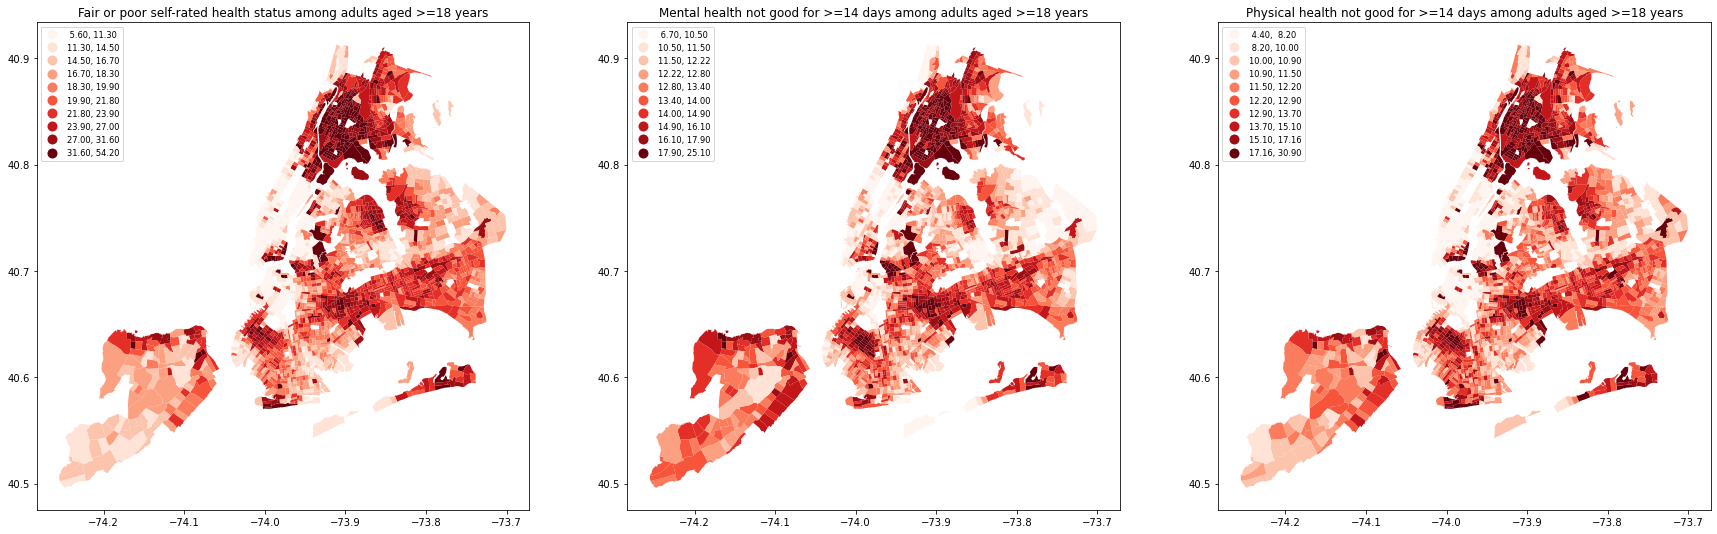

In [104]:
fig, ax = plt.subplots(1,3, figsize=(30,30))

for i,j in enumerate(HStatus['Measure'].unique()):
    HStatus[HStatus['Measure'] == j].plot(ax=ax[i], column='Data_Value', k=10, scheme='Quantiles',cmap='Reds',
                                             legend=True, legend_kwds={'loc':'upper left','fontsize':'small'})
    
    
    label = j
    ax[i].set_title(label)
    
plt.show()

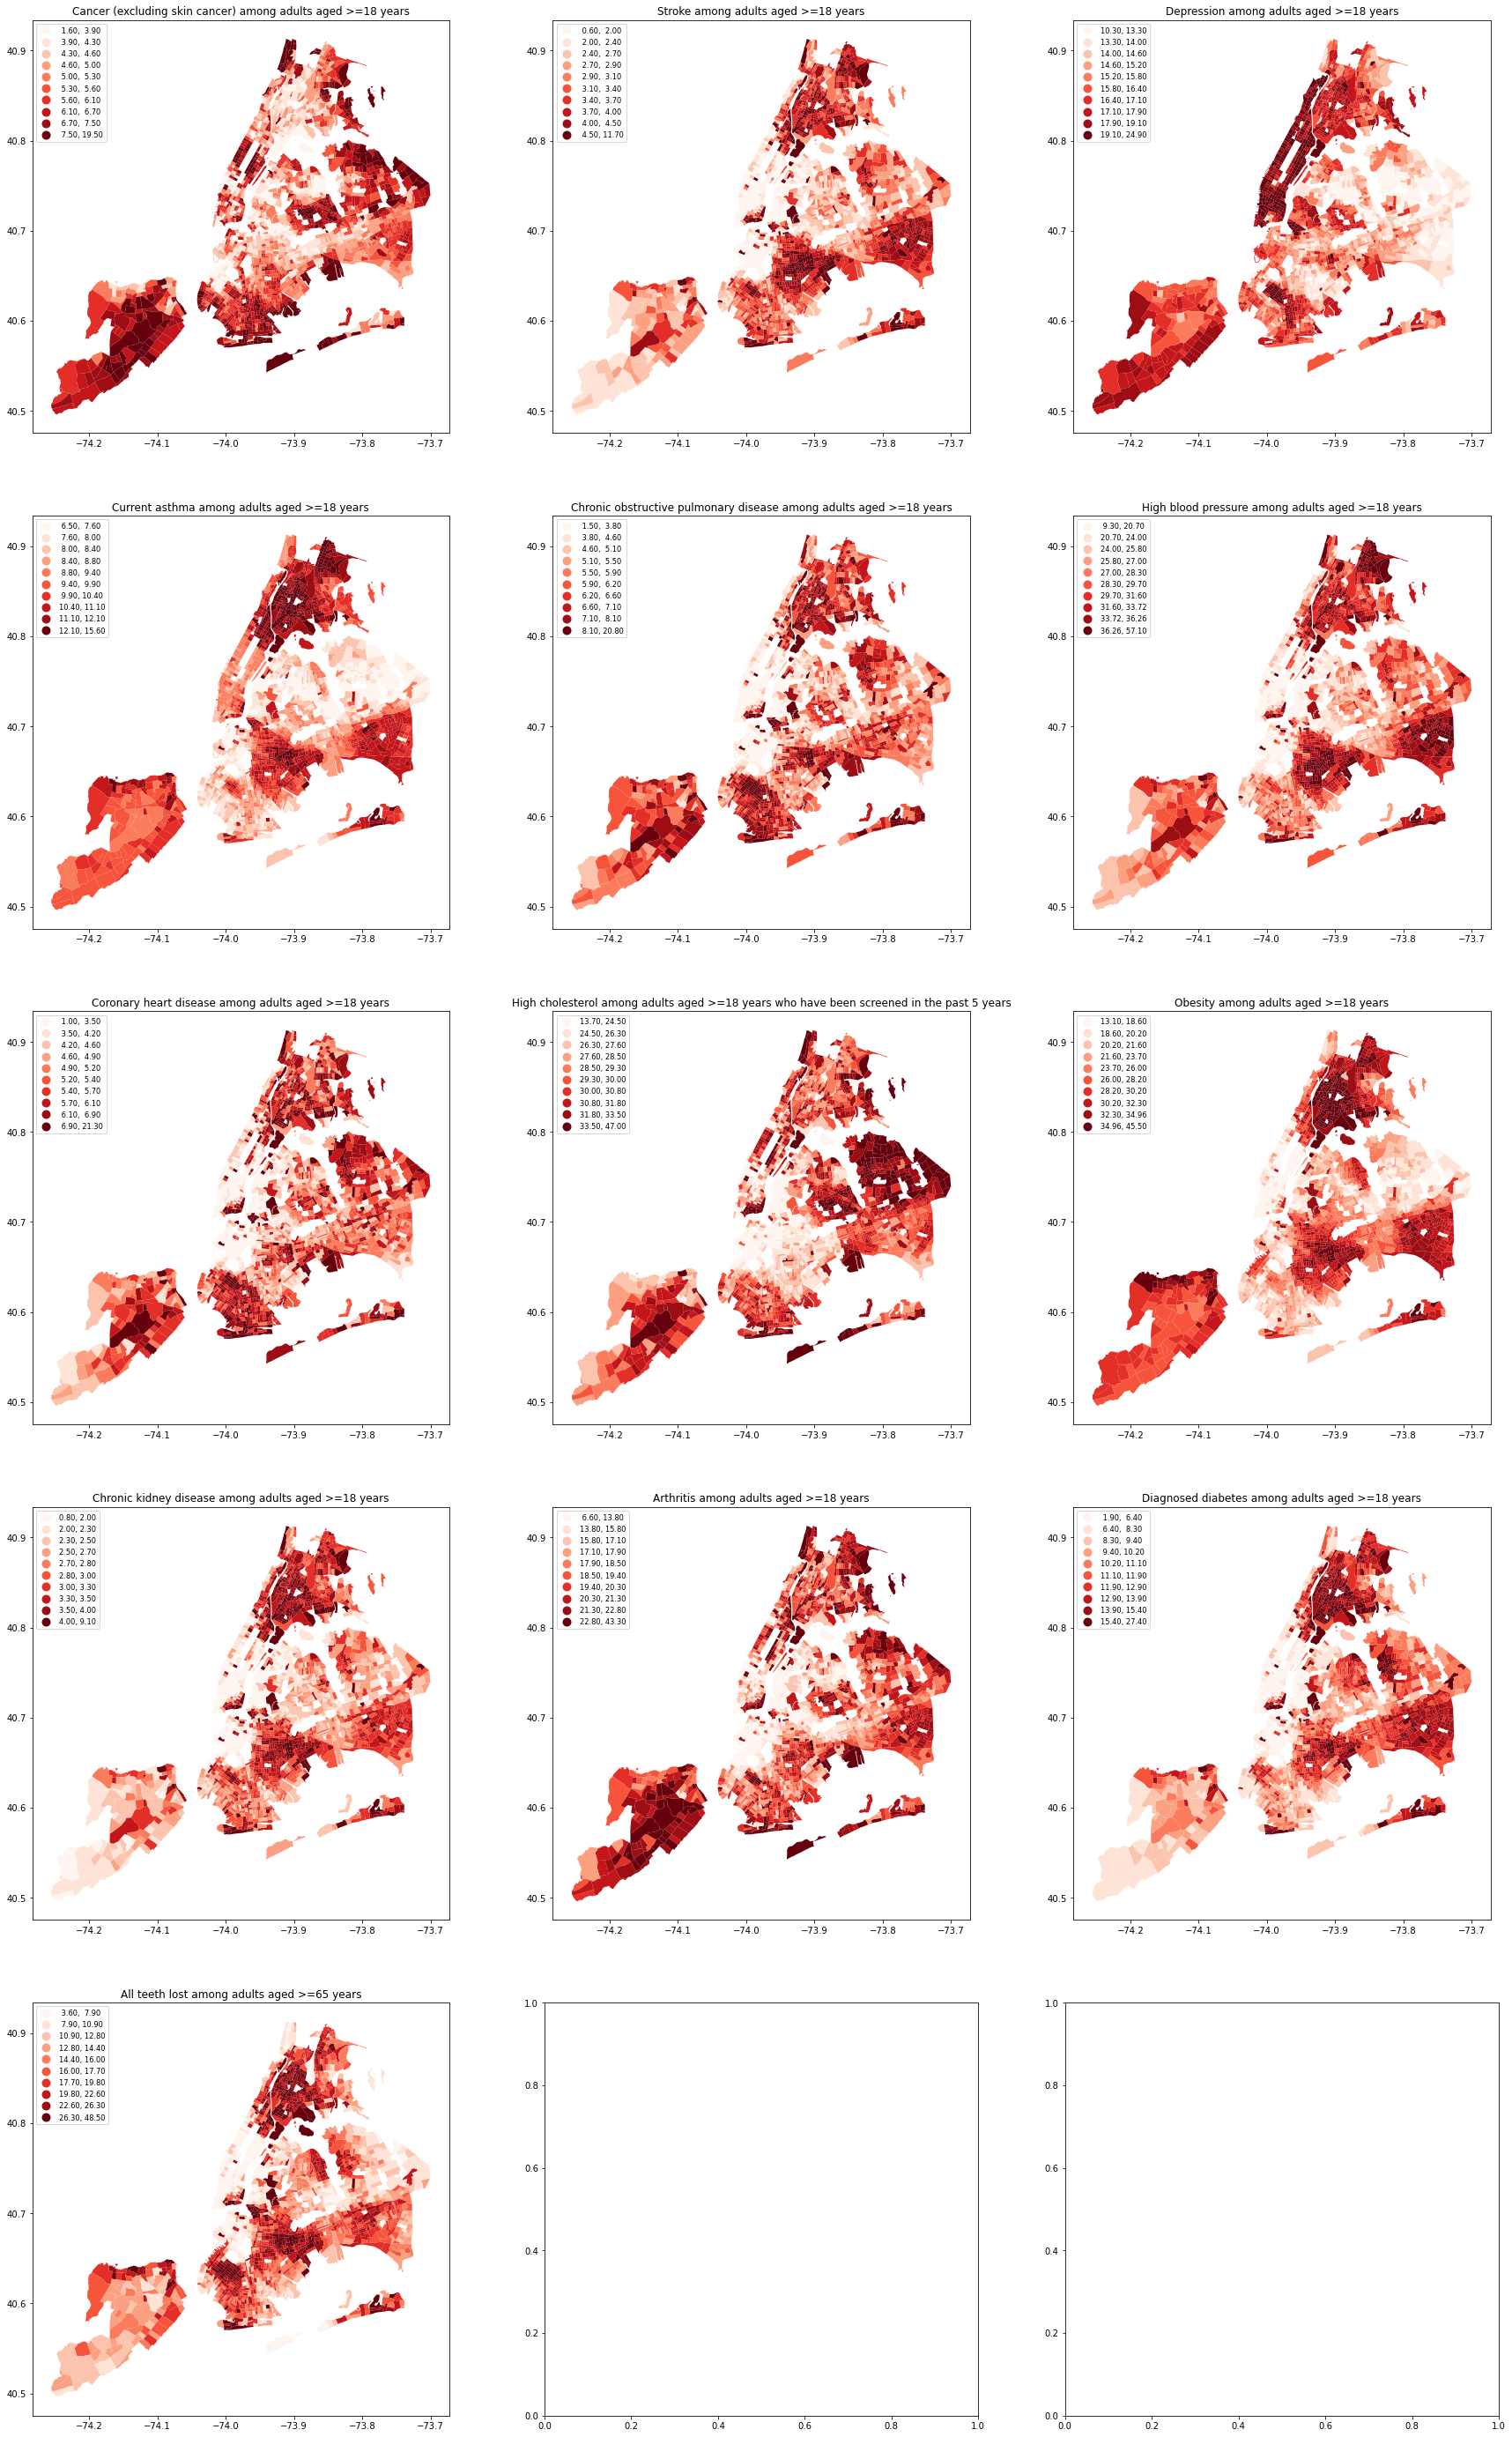

In [105]:
fig, ax = plt.subplots(5,3, figsize=(30,50))

for i,j in enumerate(HOutcomes['Measure'].unique()):
    HOutcomes[HOutcomes['Measure'] == j].plot(ax=ax[i//3][i%3], column='Data_Value', k=10, scheme='Quantiles',cmap='Reds',
                                             legend=True, legend_kwds={'loc':'upper left','fontsize':'small'})
    
    
    label = j
    ax[i//3][i%3].set_title(label)

#plt.tight_layout()
plt.show()

### Health Status
**GHLTH:** Fair or poor self-rated health status among adults aged >= 18 years
**MHLTH:** Mental health not good for >=14 days among adults aged >= 18 years
**PHLTH:** Physical health not good for >=14 days among adults aged >= 18 years

In [106]:
HStatus.head()

,Year,StateAbbr,Category,Measure,Data_Value,TotalPopulation,CategoryID,MeasureId,boro_name,ct2010,ntacode,ntaname,shape_area,shape_leng,geometry,GeoID
20,2019,NY,Health Status,Fair or poor self-rated health status among ad...,25.7,1907,HLTHSTAT,GHLTH,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.542570,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100
21,2019,NY,Health Status,Mental health not good for >=14 days among adu...,14.7,1907,HLTHSTAT,MHLTH,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.542570,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100
23,2019,NY,Health Status,Physical health not good for >=14 days among a...,13.8,1907,HLTHSTAT,PHLTH,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.542570,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100
36,2019,NY,Health Status,Physical health not good for >=14 days among a...,15.5,2303,HLTHSTAT,PHLTH,Bronx,037000,BX44,Williamsbridge-Olinville,1.709084e+06,5159.570728,"POLYGON ((-73.85651 40.87422, -73.85655 40.873...",36005037000
38,2019,NY,Health Status,Mental health not good for >=14 days among adu...,16.5,2303,HLTHSTAT,MHLTH,Bronx,037000,BX44,Williamsbridge-Olinville,1.709084e+06,5159.570728,"POLYGON ((-73.85651 40.87422, -73.85655 40.873...",36005037000


In [107]:
# pivot table
HStatus = HStatus.pivot_table(index='GeoID',columns='MeasureId', values='Data_Value')
HStatus.head()

MeasureId,GHLTH,MHLTH,PHLTH
GeoID,,,
36005000100,30.3,19.3,14.0
36005000200,25.4,13.9,13.4
36005000400,19.6,12.4,10.8
36005001600,31.1,16.0,16.8
36005001900,26.2,16.6,13.9


### Health Outcomes

In [108]:
HOutcomes.head()

,Year,StateAbbr,Category,Measure,Data_Value,TotalPopulation,CategoryID,MeasureId,boro_name,ct2010,ntacode,ntaname,shape_area,shape_leng,geometry,GeoID
3,2019,NY,Health Outcomes,Cancer (excluding skin cancer) among adults ag...,4.7,1907,HLTHOUT,CANCER,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.54257,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100
4,2019,NY,Health Outcomes,Stroke among adults aged >=18 years,3.3,1907,HLTHOUT,STROKE,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.54257,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100
5,2019,NY,Health Outcomes,Depression among adults aged >=18 years,15.7,1907,HLTHOUT,DEPRESSION,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.54257,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100
8,2019,NY,Health Outcomes,Current asthma among adults aged >=18 years,11.1,1907,HLTHOUT,CASTHMA,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.54257,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100
11,2019,NY,Health Outcomes,Chronic obstructive pulmonary disease among ad...,5.4,1907,HLTHOUT,COPD,Bronx,007100,BX34,Melrose South-Mott Haven North,2.841871e+06,8603.54257,"POLYGON ((-73.90842 40.82218, -73.90850 40.821...",36005007100


In [109]:
# pivot table
HOutcomes = HOutcomes.pivot_table(index='GeoID',columns='MeasureId', values='Data_Value')
HOutcomes.head()

MeasureId,ARTHRITIS,BPHIGH,CANCER,CASTHMA,CHD,COPD,DEPRESSION,DIABETES,HIGHCHOL,KIDNEY,OBESITY,STROKE,TEETHLOST
GeoID,,,,,,,,,,,,,
36005000100,11.4,28.6,2.1,11.1,3.8,5.5,15.1,9.4,22.1,2.3,34.5,2.7,29.4
36005000200,18.0,30.3,4.9,10.4,5.2,5.2,15.2,13.6,30.1,3.3,31.8,3.1,15.5
36005000400,15.6,26.8,4.5,9.8,3.9,3.9,14.5,11.0,28.0,2.7,30.2,2.4,10.6
36005001600,22.2,35.8,5.7,11.8,7.0,7.3,16.4,16.8,32.2,4.3,35.0,4.3,19.3
36005001900,15.2,28.1,3.5,10.8,4.7,5.4,16.6,11.6,26.1,2.9,33.9,2.8,18.6


In [110]:
# save file
HStatus.to_csv('./Data/Processed_Data/Domain/Health_Status.csv')
HOutcomes.to_csv('./Data/Processed_Data/Domain/Health_Outcomes.csv')

# Independent Variables

## Social & Economic

**SE_Unemploy:** Unemployment rate
    
**SE_Income:** Median household incomes(dollars)

**SE_Cash:** Percent households receiving cash public assistance

**SE_Food:** Percent households receiving Food Stamps/Supplemental Nutrition Assistance Program

**SE_Insurance:** Percent individuals with health insurance coverage

**SE_Poverty:** Percent individuals ages 18 years and over with incomes below the federal poverty level in the past 12 months

**SE_English:** Percent citizens 18 years old and over speak English less than very well

**Data Source:** ACS 5 years estimate

https://data.census.gov/cedsci/table?g=0500000US36005%241400000,36047%241400000,36061%241400000,36081%241400000,36085%241400000

**Geography:** Census Tract

**Date:** 2019

In [35]:
SocEco = pd.read_csv('./Data/Raw_Data/Social_Economic/ACSDP5Y2019.DP03_2022-03-06T215807/ACSDP5Y2019.DP03_data_with_overlays_2021-12-29T091139.csv'
            , skiprows=1, usecols=[#'Percent!!EMPLOYMENT STATUS!!Population 16 years and over'
                                   #'Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households'
                                   'Percent!!EMPLOYMENT STATUS!!Civilian labor force!!Unemployment Rate'
                                   ,'Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)'
                                   ,'Percent!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!With Food Stamp/SNAP benefits in the past 12 months'
                                   ,'Percent!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!With cash public assistance income'
                                   ,'Percent!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!With health insurance coverage'
                                   ,'Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over'
                                   ,'id'
                                   #,'Geographic Area Name'
                                  ]
                    )
SocEco.head()

,Percent!!EMPLOYMENT STATUS!!Civilian labor force!!Unemployment Rate,Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars),Percent!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!With cash public assistance income,Percent!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!With Food Stamp/SNAP benefits in the past 12 months,Percent!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!With health insurance coverage,Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over,id
0,-,-,-,-,-,-,1400000US36005000100
1,13.5,51100,8.3,21.5,93.3,23.0,1400000US36005000200
2,6.2,78409,7.1,8.4,94.9,7.7,1400000US36005000400
3,4.8,34093,7.7,35.3,93.6,25.3,1400000US36005001600
4,10.7,45156,7.7,31.6,85.2,30.4,1400000US36005001900


In [36]:
language = pd.read_csv('./Data/Raw_Data/Social_Economic/ACSST5Y2019.S1601_2022-03-13T133928/ACSST5Y2019.S1601_data_with_overlays_2022-03-13T133918.csv'
           ,skiprows=1
           ,usecols=['id'
                     ,'Estimate!!Percent speak English less than very well"!!Percent of specified language speakers!!CITIZENS 18 YEARS AND OVER!!All citizens 18 years old and over"'
                    ])
language.head()

,id,"Estimate!!Percent speak English less than very well""!!Percent of specified language speakers!!CITIZENS 18 YEARS AND OVER!!All citizens 18 years old and over"""
0,1400000US36005000100,7.9
1,1400000US36005000200,15.4
2,1400000US36005000400,10.8
3,1400000US36005001600,17.3
4,1400000US36005001900,11.1


In [37]:
# merge
Social_Economic = SocEco.merge(language)
Social_Economic = Social_Economic.rename(columns={'Percent!!EMPLOYMENT STATUS!!Civilian labor force!!Unemployment Rate':'SE_Unemploy'
                               ,'Estimate!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!Median household income (dollars)':'SE_Income'
                               ,'Percent!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!With cash public assistance income':'SE_Cash'
                                ,'Percent!!INCOME AND BENEFITS (IN 2019 INFLATION-ADJUSTED DOLLARS)!!Total households!!With Food Stamp/SNAP benefits in the past 12 months':'SE_Food'
                                ,'Percent!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!With health insurance coverage':'SE_Insurance'
                                ,'Percent!!PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over':'SE_Poverty'
                                ,'Estimate!!Percent speak English less than very well"!!Percent of specified language speakers!!CITIZENS 18 YEARS AND OVER!!All citizens 18 years old and over"':'SE_English'
                                ,'id':'GeoID'
                               })
Social_Economic['GeoID'] = Social_Economic['GeoID'].map(lambda x: x.split('US',1)[1]).astype('int')
Social_Economic = Social_Economic.set_index('GeoID')
Social_Economic.head()

,SE_Unemploy,SE_Income,SE_Cash,SE_Food,SE_Insurance,SE_Poverty,SE_English
GeoID,,,,,,,
36005000100,-,-,-,-,-,-,7.9
36005000200,13.5,51100,8.3,21.5,93.3,23.0,15.4
36005000400,6.2,78409,7.1,8.4,94.9,7.7,10.8
36005001600,4.8,34093,7.7,35.3,93.6,25.3,17.3
36005001900,10.7,45156,7.7,31.6,85.2,30.4,11.1


In [38]:
# sanity check
Social_Economic = Social_Economic.replace({'-':np.nan}).dropna()
Social_Economic['SE_Income'] = Social_Economic['SE_Income'].replace({'250,000+':250000})
Social_Economic = Social_Economic.astype('float')

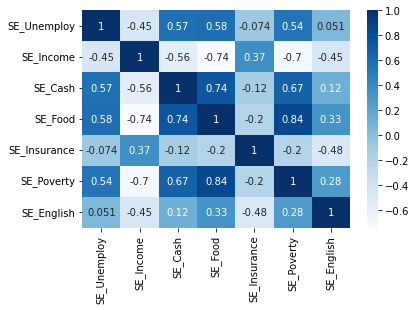

In [39]:
corr = Social_Economic.corr()
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [40]:
# strong correlation (pearson correlation > 0.5):
# unemployment: income, cash, food, poverty
# income: cash, food, poverty, english
# cash: food, poverty
# so in next step, we will using PCA combine unemployment rate, income, cash, food, and poverty as an index

In [41]:
# save file
Social_Economic.to_csv('./Data/Processed_Data/Domain/Social_Economic.csv')

## Education(E)

**E_Advance:** Population 25 years and over who has Bachelor's degree or higher

**E_PreS:** Population 3 to 4 years olds enrolled in school

**E_HighS:** Population 15 to 17 year olds enrolled in school


**Data Source:** ACS 5 years estimate

https://data.census.gov/cedsci/table?g=0500000US36005%241400000,36047%241400000,36061%241400000,36081%241400000,36085%241400000

**Geography:** Census Tract

**Date:** 2019

In [42]:
higherEDU = pd.read_csv('./Data/Raw_Data/Education/ACSST5Y2019.S1501_2022-03-13T140446/ACSST5Y2019.S1501_data_with_overlays_2022-02-15T165745.csv'
           ,skiprows=1
           ,usecols=['id'
                     #,'Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over'
                     ,'Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor\'s degree or higher'
                    ])
higherEDU.head()

,id,Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher
0,1400000US36005000100,1.5
1,1400000US36005000200,29.4
2,1400000US36005000400,28.4
3,1400000US36005001600,18.5
4,1400000US36005001900,24.6


In [43]:
School = pd.read_csv('./Data/Raw_Data/Education/ACSST5Y2019.S1401_2022-03-13T221441/ACSST5Y2019.S1401_data_with_overlays_2022-03-13T141709.csv'
                    ,skiprows=1
                    ,usecols=['Estimate!!Percent!!Population 3 to 4 years!!3 to 4 year olds enrolled in school'
                              ,'id'
                              ,'Estimate!!Percent!!Population 15 to 17!!15 to 17 year olds enrolled in school'])

School.head()

,id,Estimate!!Percent!!Population 3 to 4 years!!3 to 4 year olds enrolled in school,Estimate!!Percent!!Population 15 to 17!!15 to 17 year olds enrolled in school
0,1400000US36005000100,-,0.0
1,1400000US36005000200,29.9,100.0
2,1400000US36005000400,53.1,100.0
3,1400000US36005001600,76.6,90.6
4,1400000US36005001900,25.3,93.6


In [44]:
Education = pd.merge(higherEDU, School)
Education = Education.rename(columns={'Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor\'s degree or higher':'E_Advance'
                                     ,'Estimate!!Percent!!Population 3 to 4 years!!3 to 4 year olds enrolled in school':'E_PreS'
                                      ,'Estimate!!Percent!!Population 15 to 17!!15 to 17 year olds enrolled in school':'E_HighS'
                                      ,'id':'GeoID'
                                     })

Education['GeoID'] = Education['GeoID'].map(lambda x: x.split('US',1)[1]).astype('int')
Education = Education.set_index('GeoID')
Education

,E_Advance,E_PreS,E_HighS
GeoID,,,
36005000100,1.5,-,0.0
36005000200,29.4,29.9,100.0
36005000400,28.4,53.1,100.0
36005001600,18.5,76.6,90.6
36005001900,24.6,25.3,93.6
...,...,...,...
36085030302,30.1,83.7,89.1
36085031901,16.7,0.0,100.0
36085031902,27.2,32.4,100.0


In [45]:
# sanity check
Education = Education.replace({'-':np.nan}).dropna()
Education = Education.astype('float')
len(Education)

2019

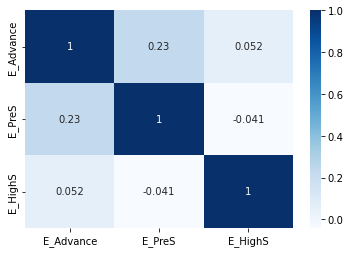

In [46]:
corr = Education.corr()
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [47]:
# save file
Education.to_csv('./Data/Processed_Data/Domain/Education.csv')

## Natural Environment (NE)
**NE_Tem:** Typical summer day surface temperature

**NE_PM25:** PM2.5 levels in air, µg/m3 annual avg.

**NE_Ozone:** Ozone summer seasonal avg. of daily maximum 8-hour concentration in air in parts per billion

### Surface Temperature

**Description:** Mean census tract-wide provisional surface temperature on typical summer day, Aug 30, 2019

**Geography:** 30-meter x 30-meter raster, aggregated to census tract

**Date:** Captured Aug 30, 2019

**Sources:** NOAA Climate Data Online, USGS Landsat Level 2 Surface Temperature Science Product/Landsat Analysis Ready Data (ARD) bundle
https://earthexplorer.usgs.gov/

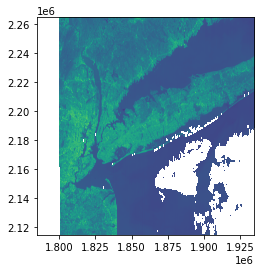

<AxesSubplot:>

In [48]:
# read surface temperature raster data
st = rasterio.open('./Data/Raw_Data/Environment/LC08_CU_029007_20190830_20190919_C01_V01_ST/LC08_CU_029007_20190830_20190919_C01_V01_ST.tif'
                   , mode='r')
show(st)

In [49]:
# read census tract data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson', driver='GeoJSON')
ct2010.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,GeoID,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,36085000900,"POLYGON ((-74.07921 40.64343, -74.07914 40.643..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,36061009800,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
2,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,36061010200,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
3,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,36061010400,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."
4,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,36061011300,"POLYGON ((-73.98412 40.75484, -73.98460 40.754..."


In [50]:
# project census tract to same coordinate system
ct2010 = ct2010.to_crs(st.crs)

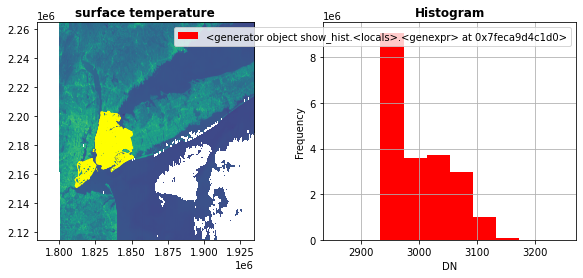

In [51]:
# plotting the raster and the census tract together
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
show(st,ax=ax1, title = 'surface temperature')
ct2010.plot(ax=ax1, facecolor='None', edgecolor='yellow')

show_hist(st, title='Histogram',ax=ax2) #Kelvins temperature (*10)
plt.show()

In [52]:
st_array = st.read(1) # assign raster values to a numpy nd array
affine = st.transform

# calculating the zonal statistics
avg_st = rasterstats.zonal_stats(ct2010,st_array, affine=affine
                                 , stats=['mean'] #max min
                                , geojson_out = True)

/Users/taoliang/opt/anaconda3/envs/MLC/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [53]:
# extracting the average surface temperature from the list
avg_surfaceT = []
i = 0
while i< len(avg_st):
    avg_surfaceT.append(avg_st[i]['properties'])
    i = i+1
    
# transfering the list to pandas dataframe
avg_surfaceT = pd.DataFrame(avg_surfaceT)
avg_surfaceT.head()

,GeoID,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,mean
0,36085000900,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,3076.366795
1,36061009800,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,3079.360406
2,36061010200,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,3050.124352
3,36061010400,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,3064.435233
4,36061011300,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,3064.309278


In [54]:
# Convert 10*Kelvin temperature to Fahrenheit
avg_surfaceT['SurfaceT_F'] = 9*(avg_surfaceT['mean']/10-273.15)/5+32
avg_surfaceT.head()

,GeoID,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,mean,SurfaceT_F
0,36085000900,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,3076.366795,94.076023
1,36061009800,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,3079.360406,94.614873
2,36061010200,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,3050.124352,89.352383
3,36061010400,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,3064.435233,91.928342
4,36061011300,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,3064.309278,91.905670


In [55]:
avg_surfaceT = avg_surfaceT[['GeoID','SurfaceT_F']]

### PM 2.5 and Ozone

EJScreen is an environmental justice mapping and screening tool that provides EPA with a nationally consistent dataset and approach for combining environmental and demographic indicators. **EJScreen 2021 version contains 2018 PM2.5 and Ozone data**

**Data Source:** https://gaftp.epa.gov/EJSCREEN/

**Geography:** Census Tract

**Date:** 2018(EJScreen 2021)

For more information:

https://www.epa.gov/ejscreen/overview-environmental-indicators-ejscreen

https://ejscreen.epa.gov/mapper/

In [56]:
EJSCREEN = pd.read_csv('./Data/Raw_Data/Environment/EJSCREEN_2021_StatePctile_Tracts.csv', usecols=['ID','STATE_NAME','PM25','OZONE'])
EJSCREEN.head()

,ID,STATE_NAME,OZONE,PM25
0,1001020100,Alabama,37.010497,9.152519
1,1001020200,Alabama,37.038957,9.183280
2,1001020300,Alabama,37.069151,9.207049
3,1001020400,Alabama,37.087437,9.231752
4,1001020500,Alabama,37.123515,9.242796


In [57]:
EJSCREEN[EJSCREEN.ID.isin(HStatus.index.unique())]

,ID,STATE_NAME,OZONE,PM25
43283,36005000100,New York,42.154011,9.029846
43284,36005000200,New York,42.521795,8.939136
43285,36005000400,New York,42.587127,8.902753
43286,36005001600,New York,42.587327,8.949253
43287,36005001900,New York,42.051273,9.157725
...,...,...,...,...
47142,36085029104,New York,41.994270,8.828076
47143,36085030301,New York,41.961233,8.851841
47144,36085030302,New York,41.954758,8.873564
47145,36085031901,New York,41.947769,8.901235


In [58]:
Environment = pd.merge(avg_surfaceT,EJSCREEN, left_on='GeoID', right_on='ID')
Environment = Environment.rename(columns={'OZONE':'NE_Ozone'
                                         ,'PM25':'NE_PM25'
                                         ,'SurfaceT_F':'NE_Tem'})

Environment = Environment.drop(columns=['ID','STATE_NAME']).set_index('GeoID')
Environment.head()

,NE_Tem,NE_Ozone,NE_PM25
GeoID,,,
36085000900,94.076023,41.671695,8.968913
36061009800,94.614873,41.693379,9.237539
36061010200,89.352383,41.701241,9.244300
36061010400,91.928342,41.691546,9.259344
36061011300,91.905670,41.649439,9.262772


In [59]:
len(Environment)

2165

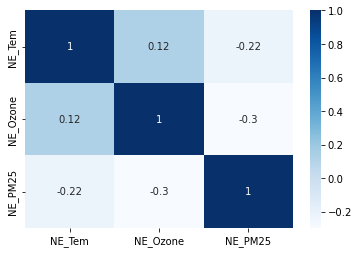

In [60]:
corr = Environment.corr()
sns.heatmap(corr, cmap="Blues", annot=True)
plt.show()

In [61]:
# save file
Environment.to_csv('./Data/Processed_Data/Domain/Environment.csv')

## Built Environment (BE)
**BE_TreeD:** Street trees density (trees per acre)

**BE_LandMIX:** Land-use mix of commercial, residential and open space uses

**BE_nodeD:** Intersection density in terms of pedestrian-oriented intersections.(number of intersection per acre)

**BE_JFood:** Numbers of fast food restaurants within 15 min walk distance (0.8 mile)

**BE_HFood:** Numbers of supermarkets within 15 min walk distance (0.8 mile)

**BE_WalkVSDrive:** The area of sidewalks divided by the sum of the area of the roadway segment and the area sidewalks in a given census tract

**BE_Transit:** Numbers of Transits(train, subway, bus, or ferry stop.) within 15 min walk distance (0.8 mile)

**BE_Park:** Area(arce) of parks within 15 min walk distance (0.8 mile)

### BE_TreeD: Street Trees Density

**Data Source:** 2015 Street Tree Census - Tree Data (Department of Parks and Recreation (DPR))

https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/pi5s-9p35

**Geography:** Point/census tract

**Date:** Created June 3, 2016; Updated September 13, 2018

In [57]:
Tree = gpd.read_file('./Data/Raw_Data/Built_Environment/2015 Street Tree Census - Tree Data.zip')

In [58]:
Tree.head()

,address,block_id,boro_ct,borocode,boroname,brnch_ligh,brnch_othe,brnch_shoe,cb_num,cncldist,created_at,curb_loc,guards,health,latitude,longitude,nta,nta_name,problems,root_grate,root_other,root_stone,sidewalk,spc_common,spc_latin,st_assem,st_senate,state,status,steward,stump_diam,tree_dbh,tree_id,trnk_light,trnk_other,trnk_wire,user_type,x_sp,y_sp,zip_city,zipcode,geometry
0,108-005 70 AVENUE,348711.0,4073900,4,Queens,No,No,No,406,29.0,08/27/2015,OnCurb,None,Fair,40.723092,-73.844215,QN17,Forest Hills,None,No,No,No,NoDamage,red maple,Acer rubrum,28.0,16.0,New York,Alive,None,0.0,3.0,180683.0,No,No,No,TreesCount Staff,1.027431e+06,202756.768749,Forest Hills,11375,POINT (-73.84422 40.72309)
1,147-074 7 AVENUE,315986.0,4097300,4,Queens,No,No,No,407,19.0,09/03/2015,OnCurb,None,Fair,40.794111,-73.818679,QN49,Whitestone,Stones,No,No,Yes,Damage,pin oak,Quercus palustris,27.0,11.0,New York,Alive,None,0.0,21.0,200540.0,No,No,No,TreesCount Staff,1.034456e+06,228644.837379,Whitestone,11357,POINT (-73.81868 40.79411)
2,390 MORGAN AVENUE,218365.0,3044900,3,Brooklyn,No,No,No,301,34.0,09/05/2015,OnCurb,None,Good,40.717581,-73.936608,BK90,East Williamsburg,None,No,No,No,Damage,honeylocust,Gleditsia triacanthos var. inermis,50.0,18.0,New York,Alive,1or2,0.0,3.0,204026.0,No,No,No,Volunteer,1.001823e+06,200716.891267,Brooklyn,11211,POINT (-73.93661 40.71758)
3,1027 GRAND STREET,217969.0,3044900,3,Brooklyn,No,No,No,301,34.0,09/05/2015,OnCurb,None,Good,40.713537,-73.934456,BK90,East Williamsburg,Stones,No,No,Yes,Damage,honeylocust,Gleditsia triacanthos var. inermis,53.0,18.0,New York,Alive,None,0.0,10.0,204337.0,No,No,No,Volunteer,1.002420e+06,199244.253136,Brooklyn,11211,POINT (-73.93446 40.71354)
4,603 6 STREET,223043.0,3016500,3,Brooklyn,No,No,No,306,39.0,08/30/2015,OnCurb,None,Good,40.666778,-73.975979,BK37,Park Slope-Gowanus,Stones,No,No,Yes,Damage,American linden,Tilia americana,44.0,21.0,New York,Alive,None,0.0,21.0,189565.0,No,No,No,Volunteer,9.909138e+05,182202.425999,Brooklyn,11215,POINT (-73.97598 40.66678)


In [59]:
len(Tree)

683788

In [60]:
len(Tree.tree_id.unique())

683788

In [61]:
# read census tract data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson', driver='GeoJSON')
ct2010.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,GeoID,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,36085000900,"POLYGON ((-74.07921 40.64343, -74.07914 40.643..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,36061009800,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
2,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,36061010200,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
3,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,36061010400,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."
4,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,36061011300,"POLYGON ((-73.98412 40.75484, -73.98460 40.754..."


In [62]:
Tree.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [63]:
ct2010.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [64]:
# spatial join with census tract
Tree_ct = gpd.sjoin(Tree, ct2010, how="inner", op='intersects')
Tree_ct.head()

,address,block_id,boro_ct,borocode,boroname,brnch_ligh,brnch_othe,brnch_shoe,cb_num,cncldist,created_at,curb_loc,guards,health,latitude,longitude,nta,nta_name,problems,root_grate,root_other,root_stone,sidewalk,spc_common,spc_latin,st_assem,st_senate,state,status,steward,stump_diam,tree_dbh,tree_id,trnk_light,trnk_other,trnk_wire,user_type,x_sp,y_sp,zip_city,zipcode,geometry,index_right,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,GeoID
0,108-005 70 AVENUE,348711.0,4073900,4,Queens,No,No,No,406,29.0,08/27/2015,OnCurb,None,Fair,40.723092,-73.844215,QN17,Forest Hills,None,No,No,No,NoDamage,red maple,Acer rubrum,28.0,16.0,New York,Alive,None,0.0,3.0,180683.0,No,No,No,TreesCount Staff,1.027431e+06,202756.768749,Forest Hills,11375,POINT (-73.84422 40.72309),420,4,4073900,Queens,I,073900,739,QN17,Forest Hills,4108,2.410956e+06,7295.047527,36081073900
329,109-005 QUEENS BOULEVARD,348611.0,4073900,4,Queens,No,No,No,406,29.0,08/27/2015,OnCurb,None,Good,40.720999,-73.842365,QN17,Forest Hills,Stones,No,No,Yes,NoDamage,tulip-poplar,Liriodendron tulipifera,28.0,16.0,New York,Alive,None,0.0,32.0,179127.0,No,No,No,TreesCount Staff,1.027945e+06,201995.387398,Forest Hills,11375,POINT (-73.84237 40.72100),420,4,4073900,Queens,I,073900,739,QN17,Forest Hills,4108,2.410956e+06,7295.047527,36081073900
582,69-067 108 STREET,348714.0,4073900,4,Queens,No,No,No,406,29.0,08/27/2015,OnCurb,None,Fair,40.723119,-73.844461,QN17,Forest Hills,Stones,No,No,Yes,Damage,honeylocust,Gleditsia triacanthos var. inermis,28.0,16.0,New York,Alive,None,0.0,21.0,180699.0,No,No,No,TreesCount Staff,1.027363e+06,202766.529884,Forest Hills,11375,POINT (-73.84446 40.72312),420,4,4073900,Queens,I,073900,739,QN17,Forest Hills,4108,2.410956e+06,7295.047527,36081073900
623,108-021 70 AVENUE,348711.0,4073900,4,Queens,No,No,No,406,29.0,08/27/2015,OnCurb,None,Good,40.723229,-73.843754,QN17,Forest Hills,None,No,No,No,Damage,Callery pear,Pyrus calleryana,28.0,16.0,New York,Alive,None,0.0,3.0,180679.0,No,No,No,TreesCount Staff,1.027559e+06,202807.007494,Forest Hills,11375,POINT (-73.84375 40.72323),420,4,4073900,Queens,I,073900,739,QN17,Forest Hills,4108,2.410956e+06,7295.047527,36081073900
1061,109-019 72 AVENUE,348542.0,4073900,4,Queens,No,No,No,406,29.0,08/27/2015,OnCurb,None,Good,40.720882,-73.840993,QN17,Forest Hills,Stones,No,No,Yes,NoDamage,Norway maple,Acer platanoides,28.0,16.0,New York,Alive,None,0.0,7.0,179181.0,No,No,No,TreesCount Staff,1.028326e+06,201953.285776,Forest Hills,11375,POINT (-73.84099 40.72088),420,4,4073900,Queens,I,073900,739,QN17,Forest Hills,4108,2.410956e+06,7295.047527,36081073900


In [98]:
Tree_ct_geo = Tree_ct.groupby('GeoID').agg({'tree_id':'count'}).merge(ct2010[['GeoID','geometry']], left_index=True, right_on='GeoID')
Tree_ct_geo.head()

,tree_id,GeoID,geometry
2157,377,36005000200,"POLYGON ((-73.85652 40.80524, -73.85652 40.805..."
1374,455,36005000400,"POLYGON ((-73.84611 40.81310, -73.84647 40.812..."
994,523,36005001600,"POLYGON ((-73.85514 40.82244, -73.85497 40.821..."
1945,507,36005001900,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
1060,422,36005002000,"POLYGON ((-73.86246 40.81925, -73.86208 40.817..."


In [99]:
Tree_ct_geo.describe()

,tree_id,GeoID
count,2152.000000,2.152000e+03
mean,317.705390,3.605475e+10
std,311.252666,2.593403e+07
min,2.000000,3.600500e+10
25%,169.750000,3.604703e+10
50%,237.000000,3.604712e+10
75%,342.000000,3.608103e+10
max,3776.000000,3.608503e+10


In [100]:
Tree_ct_geo = gpd.GeoDataFrame(Tree_ct_geo, geometry=Tree_ct_geo.geometry,crs=4326).to_crs('EPSG:2263')

In [101]:
Tree_ct_geo.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [102]:
# calculate area. unit is square foot
Tree_ct_geo['area'] = Tree_ct_geo['geometry'].area
Tree_ct_geo.head()  

,tree_id,GeoID,geometry,area
2157,377,36005000200,"POLYGON ((1023972.528 232680.658, 1023970.431 ...",5.009890e+06
1374,455,36005000400,"POLYGON ((1026849.274 235548.774, 1026749.976 ...",8.557844e+06
994,523,36005001600,"POLYGON ((1024344.112 238946.021, 1024391.333 ...",5.221330e+06
1945,507,36005001900,"MULTIPOLYGON (((1012821.806 229228.265, 101278...",1.796100e+07
1060,422,36005002000,"POLYGON ((1022317.859 237780.872, 1022425.769 ...",4.336906e+06


In [103]:
Tree_ct_geo['BE_TreeD'] = Tree_ct_geo['tree_id']/(Tree_ct_geo['area']/43560) # 1 acre equals 43560 square feet
BE_TreeD = Tree_ct_geo[['BE_TreeD','GeoID']]
BE_TreeD.head()

,BE_TreeD,GeoID
2157,3.277940,36005000200
1374,2.315981,36005000400
994,4.363233,36005001600
1945,1.229604,36005001900
1060,4.238579,36005002000


In [105]:
len(BE_TreeD)

2152

In [104]:
# save file
BE_TreeD.to_csv('./Data/Processed_Data/BE_TreeD.csv')

### BE_LandMIX: 

**Description:** Land-use mix of commercial, residential and open space uses

**Data Source:** PLUTO Release 19v1

https://www1.nyc.gov/site/planning/data-maps/open-data/bytes-archive.page?sorts[year]=0

**Geography:** PLUTO Tax Lot

**Date:** 2019

### landuse：
01 One & Two Family Buildings\
02 Multi-Family Walk-Up Buildings\
03 Multi-Family Elevator Buildings\
04 Mixed Residential & Commercial Buildings\
05 Commercial & Office Buildings\
06 Industrial & Manufacturing\
07 Transportation & Utility\
08 Public Facilities & Institutions\
09 Open Space & Outdoor Recreation\
10 Parking Facilities\
11 Vacant Land\

### For each landuse we calculate the Frequency Density(FD) and Category Ratio (CR):
## $F_i=\frac{n_i}{N_i}$
## $C_i = \frac{F_i}{\sum{F_j}}$

#### where $i$ is one land use type, $j$ is all land use types, $n$ is type $i$'s count in one zone, $N_i$ is type $i$' count within the whole city

In [192]:
# landuse extracted from pluto 
pluto = pd.read_csv("./Data/Raw_Data/nyc_pluto_19v1_csv/pluto_19v1.csv")
pluto.head()

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (16,17,18,20,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,policeprct,healtharea,sanitboro,sanitsub,address,zonedist1,zonedist2,zonedist3,zonedist4,overlay1,overlay2,spdist1,spdist2,spdist3,ltdheight,splitzone,bldgclass,landuse,easements,ownertype,ownername,lotarea,bldgarea,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,otherarea,areasource,numbldgs,numfloors,unitsres,unitstotal,lotfront,lotdepth,bldgfront,bldgdepth,ext,proxcode,irrlotcode,lottype,bsmtcode,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,histdist,landmark,builtfar,residfar,commfar,facilfar,borocode,bbl,condono,tract2010,xcoord,ycoord,zonemap,zmcode,sanborn,taxmap,edesignum,appbbl,appdate,plutomapid,version,sanitdistrict,healthcenterdistrict,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate,geom
0,MN,1103,36,104.0,135.0,1003.0,2.0,6.0,10019.0,E040,18.0,4500.0,1.0,3B,801 11 AVENUE,M2-3,NaN,NaN,NaN,NaN,NaN,CL,NaN,NaN,NaN,N,G8,5.0,0.0,NaN,"801 11TH AVE.,",26817.0,57805.0,57805.0,0.0,0.0,12000.0,30737.0,0.0,0.0,15068.0,2.0,2.0,3.0,0.0,3.0,201.00,150.00,75.0,125.0,N,3.0,Y,3.0,2.0,2313900.0,4700700.0,0.0,1920.0,2006.0,2011.0,NaN,NaN,2.16,0.0,2.0,0.0,1,1011030036,NaN,135.0,986332.0,219627.0,8c,NaN,106W002,10405.0,NaN,NaN,NaN,1,19v1,4.0,15.0,NaN,NaN,07/06/2019,11/15/2018,07/29/2019,07/05/2019,07/26/2019,NaN,NaN,05/31/2019,0106000020E61000000100000001030000000100000007...
1,MN,1109,100,104.0,135.0,1000.0,2.0,3.0,10019.0,E040,18.0,4500.0,1.0,3B,PIER,M2-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,T9,7.0,0.0,X,NYS DEPT OF ENVIR CONSV,172842.0,105562.0,105562.0,0.0,0.0,0.0,0.0,0.0,0.0,105562.0,2.0,1.0,0.0,0.0,1.0,724.00,266.75,0.0,0.0,N,0.0,Y,2.0,0.0,16200000.0,34528500.0,34528500.0,2002.0,0.0,0.0,NaN,NaN,0.61,0.0,2.0,0.0,1,1011090100,NaN,135.0,985279.0,219475.0,8c,NaN,106W073,10405.0,NaN,1.011100e+09,05/23/2011,1,19v1,4.0,15.0,1.0,1.0,07/06/2019,11/15/2018,07/29/2019,07/05/2019,07/26/2019,NaN,NaN,05/31/2019,0106000020E6100000010000000103000000010000000A...
2,MN,1121,29,107.0,153.0,6000.0,3.0,6.0,10023.0,L035,20.0,4000.0,1.0,1A,80 CENTRAL PARK WEST,R10A,R8B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,D4,3.0,0.0,NaN,80 CPW APT CORP,15002.0,225552.0,31500.0,194052.0,7000.0,0.0,24500.0,0.0,0.0,0.0,2.0,1.0,24.0,165.0,168.0,75.42,174.29,75.0,172.0,N,3.0,Y,3.0,2.0,6001650.0,26984250.0,399257.0,1968.0,0.0,0.0,Upper West Side / Central Park West Historic D...,NaN,15.03,10.0,0.0,10.0,1,1011210029,NaN,153.0,990305.0,221271.0,8c,NaN,106W026,10406.0,NaN,NaN,NaN,1,19v1,7.0,15.0,NaN,NaN,07/06/2019,11/15/2018,07/29/2019,07/05/2019,07/26/2019,NaN,NaN,05/31/2019,0106000020E61000000100000001030000000100000009...
3,MN,1099,12,104.0,135.0,2005.0,2.0,3.0,10019.0,E040,18.0,4500.0,1.0,3B,631 WEST 51 STREET,M2-4,NaN,NaN,NaN,NaN,NaN,CL,NaN,NaN,NaN,N,E7,6.0,0.0,NaN,630 WEST 52ND LLC,9050.0,36184.0,36184.0,0.0,0.0,0.0,0.0,36184.0,0.0,0.0,2.0,1.0,4.0,0.0,2.0,40.00,200.83,40.0,200.0,N,3.0,Y,4.0,1.0,794250.0,3680550.0,0.0,1946.0,0.0,2016.0,NaN,NaN,4.00,0.0,5.0,0.0,1,1010990012,NaN,135.0,985450.0,218920.0,8c,NaN,105N050,10405.0,NaN,NaN,NaN,1,19v1,4.0,15.0,NaN,NaN,07/06/2019,11/15/2018,07/29/2019,07/05/2019,07/26/2019,NaN,NaN,05/31/2019,0106000020E61000000100000001030000000100000009...
4,BK,5751,49,310.0,212.0,3002.0,20.0,38.0,11219.0,E284,68.0,8020.0,3.0,4C,1073 66 STREET,R6B,NaN,NaN,NaN,C1-3,NaN,NaN,NaN,NaN,NaN,N,C0,2.0,0.0,NaN,"CHEN, QI BIN",2000.0,3600.0,0.0,2400.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,3.0,3.0,20.00,100.00,20.0,57.0,N,2.0,N,5.0,1.0,23580.0,84960.0,0.0,1930.0,0.0,0.0,NaN,NaN,1.80,2.0,0.0,2.0,3,3057510049,NaN,212.0,982378.0,168230.0,22a,NaN,311 067,31709.0,NaN,NaN,NaN,1,19v1,10.0,31.0,NaN,NaN,07/06/2019,11/15/2018,07/29/2019,07/05/2019,07/26/2019,NaN,NaN,05/31/2019,0106000020E6100000010000000103000000010000000A...


In [193]:
pluto = pluto.dropna(subset=['ct2010'])
pluto['borocode'] = pluto['borocode'].astype('int')
pluto['ct2010'] = pluto['ct2010'].astype('float')

In [194]:
len(pluto)

858882

In [198]:
ct2010['boro_code'] = ct2010['boro_code'].astype('int')
ct2010['ctlabel'] = ct2010['ctlabel'].astype('float')
ct2010.dtypes

boro_code        int64
boro_ct201      object
boro_name       object
cdeligibil      object
ct2010          object
ctlabel        float64
ntacode         object
ntaname         object
puma            object
shape_area     float64
shape_leng     float64
GeoID            int64
geometry      geometry
dtype: object

In [199]:
plutoM = pluto[['borough','ct2010','borocode','landuse']].merge(ct2010, left_on=('borocode','ct2010'), right_on=('boro_code','ctlabel'))
plutoM.head()

,borough,ct2010_x,borocode,landuse,boro_code,boro_ct201,boro_name,cdeligibil,ct2010_y,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,GeoID,geometry
0,MN,135.0,1,5.0,1,1013500,Manhattan,I,013500,135.0,MN15,Clinton,3807,4.494239e+06,14894.661613,36061013500,"POLYGON ((-73.99383 40.77293, -73.99379 40.772..."
1,MN,135.0,1,7.0,1,1013500,Manhattan,I,013500,135.0,MN15,Clinton,3807,4.494239e+06,14894.661613,36061013500,"POLYGON ((-73.99383 40.77293, -73.99379 40.772..."
2,MN,135.0,1,6.0,1,1013500,Manhattan,I,013500,135.0,MN15,Clinton,3807,4.494239e+06,14894.661613,36061013500,"POLYGON ((-73.99383 40.77293, -73.99379 40.772..."
3,MN,135.0,1,5.0,1,1013500,Manhattan,I,013500,135.0,MN15,Clinton,3807,4.494239e+06,14894.661613,36061013500,"POLYGON ((-73.99383 40.77293, -73.99379 40.772..."
4,MN,135.0,1,7.0,1,1013500,Manhattan,I,013500,135.0,MN15,Clinton,3807,4.494239e+06,14894.661613,36061013500,"POLYGON ((-73.99383 40.77293, -73.99379 40.772..."


In [200]:
len(plutoM)

857945

#### calculate landuse density at each census tract

In [201]:
landuse = plutoM.groupby(["landuse"]).agg({"borough":"count"}).rename(columns={"borough":"TotalCount"}).reset_index()
landuse

,landuse,TotalCount
0,1.0,565330
1,2.0,131207
2,3.0,12705
3,4.0,54477
4,5.0,21411
5,6.0,10486
6,7.0,6092
7,8.0,12164
8,9.0,4002
9,10.0,10180


In [202]:
## NYC Landuse Ratio
landuse["TotalCount"] / landuse["TotalCount"].sum()

0     0.660736
1     0.153350
2     0.014849
3     0.063671
4     0.025024
5     0.012256
6     0.007120
7     0.014217
8     0.004677
9     0.011898
10    0.032203
Name: TotalCount, dtype: float64

In [203]:
landuseCT = plutoM.groupby(["landuse","GeoID"]).agg({"borough":"count"}).rename(columns={"borough":"CTCount"}).reset_index()
landuseCT

,landuse,GeoID,CTCount
0,1.0,36005000200,705
1,1.0,36005000400,589
2,1.0,36005001600,232
3,1.0,36005001900,69
4,1.0,36005002000,265
...,...,...,...
17939,11.0,36085030301,5
17940,11.0,36085030302,28
17941,11.0,36085031901,20
17942,11.0,36085031902,47


In [204]:
landuseCountCT = landuseCT.merge(landuse,on=["landuse"])
landuseCountCT

,landuse,GeoID,CTCount,TotalCount
0,1.0,36005000200,705,565330
1,1.0,36005000400,589,565330
2,1.0,36005001600,232,565330
3,1.0,36005001900,69,565330
4,1.0,36005002000,265,565330
...,...,...,...,...
17939,11.0,36085030301,5,27553
17940,11.0,36085030302,28,27553
17941,11.0,36085031901,20,27553
17942,11.0,36085031902,47,27553


In [205]:
landuseCountCT["landuse"] = landuseCountCT["landuse"].astype(int)
landuseCountCT["F"] = landuseCountCT["CTCount"] / landuseCountCT["TotalCount"]
landuseCountCT

,landuse,GeoID,CTCount,TotalCount,F
0,1,36005000200,705,565330,0.001247
1,1,36005000400,589,565330,0.001042
2,1,36005001600,232,565330,0.000410
3,1,36005001900,69,565330,0.000122
4,1,36005002000,265,565330,0.000469
...,...,...,...,...,...
17939,11,36085030301,5,27553,0.000181
17940,11,36085030302,28,27553,0.001016
17941,11,36085031901,20,27553,0.000726
17942,11,36085031902,47,27553,0.001706


In [206]:
landuseCountCTFj = landuseCountCT.groupby(["GeoID"]).agg({"F":"sum"}).rename(columns={"F":"Fj"}).reset_index()
landuseCountCT = landuseCountCT.merge(landuseCountCTFj,on=["GeoID"])
landuseCountCT.head()

,landuse,GeoID,CTCount,TotalCount,F,Fj
0,1,36005000200,705,565330,0.001247,0.007515
1,2,36005000200,115,131207,0.000876,0.007515
2,4,36005000200,4,54477,0.000073,0.007515
3,5,36005000200,5,21411,0.000234,0.007515
4,6,36005000200,2,10486,0.000191,0.007515


In [207]:
landuseCountCT["C"] = landuseCountCT["F"] / landuseCountCT["Fj"]
landuseCountCT

,landuse,GeoID,CTCount,TotalCount,F,Fj,C
0,1,36005000200,705,565330,0.001247,0.007515,0.165944
1,2,36005000200,115,131207,0.000876,0.007515,0.116631
2,4,36005000200,4,54477,0.000073,0.007515,0.009771
3,5,36005000200,5,21411,0.000234,0.007515,0.031075
4,6,36005000200,2,10486,0.000191,0.007515,0.025380
...,...,...,...,...,...,...,...
17939,9,36081138502,25,4002,0.006247,0.006392,0.977288
17940,11,36081138502,4,27553,0.000145,0.006392,0.022712
17941,9,36085015400,4,4002,0.001000,0.001000,1.000000
17942,9,36085990100,3,4002,0.000750,0.000750,1.000000


In [216]:
landuseC=landuseCountCT.pivot_table(values='C',
         index='GeoID',
         columns='landuse',)

landuseC.fillna(value=0,inplace = True)
landuseC

landuse,1,2,3,4,5,6,7,8,9,10,11
GeoID,,,,,,,,,,,
36005000100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
36005000200,0.165944,0.116631,0.000000,0.009771,0.031075,0.025380,0.000000,0.087516,0.066501,0.091501,0.405681
36005000400,0.102824,0.064688,0.007768,0.027174,0.023047,0.000000,0.048601,0.040567,0.271267,0.145420,0.268642
36005001600,0.095253,0.162750,0.036538,0.021303,0.010841,0.000000,0.000000,0.248061,0.173994,0.091202,0.160058
36005001900,0.004123,0.011327,0.013293,0.026661,0.031551,0.496056,0.221779,0.013884,0.042200,0.096221,0.042906
...,...,...,...,...,...,...,...,...,...,...,...
36085030302,0.304460,0.010039,0.000000,0.008060,0.143552,0.000000,0.048050,0.060162,0.219432,0.057509,0.148736
36085031901,0.216512,0.017769,0.061169,0.042797,0.054445,0.000000,0.255137,0.031945,0.000000,0.038170,0.282056
36085031902,0.144153,0.015346,0.008341,0.019453,0.029697,0.212230,0.278329,0.043560,0.026480,0.041640,0.180770


In [217]:
for i in range(1,12):
    landuseC.rename(columns={i:'landuse_%i'%i}, inplace = True)
landuseC

landuse,landuse_1,landuse_2,landuse_3,landuse_4,landuse_5,landuse_6,landuse_7,landuse_8,landuse_9,landuse_10,landuse_11
GeoID,,,,,,,,,,,
36005000100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
36005000200,0.165944,0.116631,0.000000,0.009771,0.031075,0.025380,0.000000,0.087516,0.066501,0.091501,0.405681
36005000400,0.102824,0.064688,0.007768,0.027174,0.023047,0.000000,0.048601,0.040567,0.271267,0.145420,0.268642
36005001600,0.095253,0.162750,0.036538,0.021303,0.010841,0.000000,0.000000,0.248061,0.173994,0.091202,0.160058
36005001900,0.004123,0.011327,0.013293,0.026661,0.031551,0.496056,0.221779,0.013884,0.042200,0.096221,0.042906
...,...,...,...,...,...,...,...,...,...,...,...
36085030302,0.304460,0.010039,0.000000,0.008060,0.143552,0.000000,0.048050,0.060162,0.219432,0.057509,0.148736
36085031901,0.216512,0.017769,0.061169,0.042797,0.054445,0.000000,0.255137,0.031945,0.000000,0.038170,0.282056
36085031902,0.144153,0.015346,0.008341,0.019453,0.029697,0.212230,0.278329,0.043560,0.026480,0.041640,0.180770


In [218]:
# save file
landuseC.to_csv("./Data/Processed_Data/landuseC.csv")

### Land-Use Mix

For calculate land use mix, we use this formula:

$ Land Use Mix = \frac{C_{Residential} \times C_{Commercial} \times C_{Open Space}}{C_{Residential} + C_{Commercial} +C_{Open Space} }$

and

$ C_{Residential} = C_{landuse1} + C_{landuse2} + C_{landuse3} $ \
$ C_{Commercial} = C_{landuse4} + C_{landuse5} $ \
$ C_{Open Space} = C_{landuse9} $ 

In [219]:
landuseC['Residential'] = landuseC[['landuse_1','landuse_2','landuse_3']].sum(axis=1)
landuseC['Commercial'] = landuseC[['landuse_4','landuse_5']].sum(axis=1)

In [221]:
landuseC['BE_LandMIX'] = (landuseC['Residential']*landuseC['Commercial']*landuseC['landuse_9']) \
                            /(landuseC['Residential']+landuseC['Commercial']+landuseC['landuse_9'])
landuseC.BE_LandMIX.fillna(0, inplace=True)

In [222]:
landuseC

landuse,landuse_1,landuse_2,landuse_3,landuse_4,landuse_5,landuse_6,landuse_7,landuse_8,landuse_9,landuse_10,landuse_11,Residential,Commercial,BE_LandMIX
GeoID,,,,,,,,,,,,,,
36005000100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
36005000200,0.165944,0.116631,0.000000,0.009771,0.031075,0.025380,0.000000,0.087516,0.066501,0.091501,0.405681,0.282575,0.040845,0.001968
36005000400,0.102824,0.064688,0.007768,0.027174,0.023047,0.000000,0.048601,0.040567,0.271267,0.145420,0.268642,0.175280,0.050221,0.004807
36005001600,0.095253,0.162750,0.036538,0.021303,0.010841,0.000000,0.000000,0.248061,0.173994,0.091202,0.160058,0.294541,0.032144,0.003290
36005001900,0.004123,0.011327,0.013293,0.026661,0.031551,0.496056,0.221779,0.013884,0.042200,0.096221,0.042906,0.028742,0.058212,0.000547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36085030302,0.304460,0.010039,0.000000,0.008060,0.143552,0.000000,0.048050,0.060162,0.219432,0.057509,0.148736,0.314500,0.151612,0.015262
36085031901,0.216512,0.017769,0.061169,0.042797,0.054445,0.000000,0.255137,0.031945,0.000000,0.038170,0.282056,0.295450,0.097242,0.000000
36085031902,0.144153,0.015346,0.008341,0.019453,0.029697,0.212230,0.278329,0.043560,0.026480,0.041640,0.180770,0.167840,0.049150,0.000897


In [224]:
BE_LandMIX = landuseC['BE_LandMIX']

In [226]:
# save file
BE_LandMIX.to_csv("./Data/Processed_Data/BE_LandMIX.csv")

### BE_nodeD:  
**Description:** Intersection density in terms of pedestrian-oriented intersections.(number of intersection per acre)

**Data Source:** OpenStreetMap(OSM) via osmnx library

**Geography:** Point/census tract

**Date:** 2022

In [82]:
place = 'New York, USA'

In [83]:
graph = ox.graph_from_place(place, network_type='walk')

In [84]:
Walk_nodes, Walk_streets = ox.graph_to_gdfs(graph)
Walk_nodes.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
30807314,40.790720,-73.963576,4,NaN,NaN,POINT (-73.96358 40.79072)
30978752,40.774776,-73.974360,4,NaN,NaN,POINT (-73.97436 40.77478)
42421728,40.798048,-73.960044,4,traffic_signals,NaN,POINT (-73.96004 40.79805)
42421731,40.798654,-73.961474,4,traffic_signals,NaN,POINT (-73.96147 40.79865)
42421737,40.799244,-73.962873,4,traffic_signals,NaN,POINT (-73.96287 40.79924)


In [85]:
len(Walk_nodes)

180765

In [86]:
# read census tract data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson', driver='GeoJSON')
ct2010.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,GeoID,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,36085000900,"POLYGON ((-74.07921 40.64343, -74.07914 40.643..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,36061009800,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
2,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,36061010200,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
3,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,36061010400,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."
4,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,36061011300,"POLYGON ((-73.98412 40.75484, -73.98460 40.754..."


In [87]:
# spatial join with census tract
BE_nodeD = gpd.sjoin(Walk_nodes, ct2010, how="inner", op='intersects')
BE_nodeD.head()

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,y,x,street_count,highway,ref,geometry,index_right,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,GeoID
osmid,,,,,,,,,,,,,,,,,,,
30807314,40.790720,-73.963576,4,NaN,NaN,POINT (-73.96358 40.79072),2021,1,1014300,Manhattan,I,014300,143,MN99,park-cemetery-etc-Manhattan,3806,3.831238e+07,32721.097585,36061014300
30978752,40.774776,-73.974360,4,NaN,NaN,POINT (-73.97436 40.77478),2021,1,1014300,Manhattan,I,014300,143,MN99,park-cemetery-etc-Manhattan,3806,3.831238e+07,32721.097585,36061014300
42423674,40.766876,-73.979076,3,traffic_signals,NaN,POINT (-73.97908 40.76688),2021,1,1014300,Manhattan,I,014300,143,MN99,park-cemetery-etc-Manhattan,3806,3.831238e+07,32721.097585,36061014300
42424229,40.778357,-73.973008,1,NaN,NaN,POINT (-73.97301 40.77836),2021,1,1014300,Manhattan,I,014300,143,MN99,park-cemetery-etc-Manhattan,3806,3.831238e+07,32721.097585,36061014300
42424460,40.800356,-73.958053,3,NaN,NaN,POINT (-73.95805 40.80036),2021,1,1014300,Manhattan,I,014300,143,MN99,park-cemetery-etc-Manhattan,3806,3.831238e+07,32721.097585,36061014300


In [88]:
BE_nodeD = BE_nodeD.groupby('GeoID').agg({'geometry':'count'}).reset_index().merge(ct2010[['shape_area','GeoID']])
BE_nodeD.head()

,GeoID,geometry,shape_area
0,36005000200,257,5.009780e+06
1,36005000400,359,8.557953e+06
2,36005001600,239,5.221330e+06
3,36005001900,214,1.796100e+07
4,36005002000,358,4.336906e+06


In [89]:
BE_nodeD['BE_nodeD'] = BE_nodeD['geometry']/(BE_nodeD['shape_area']/43560) # 1 acre equals 43560 square feet
BE_nodeD = BE_nodeD[['GeoID','BE_nodeD']]
BE_nodeD.head()

,GeoID,BE_nodeD
0,36005000200,2.234613
1,36005000400,1.827311
2,36005001600,1.993906
3,36005001900,0.519004
4,36005002000,3.595761


In [90]:
# save file
BE_nodeD.to_csv("./Data/Processed_Data/BE_nodeD.csv")

### Creat 15min walk distance base map

#### Load  2010 Census Blocks 21A
Date: 2021 releases

In [96]:
cb2010 = gpd.read_file('./Data/Raw_Data/nycb2010_21a/nycb2010.shp')
cb2010.head()

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  # two-step construction to avoid this
/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  # two-step construction to avoid this


,CB2010,BoroCode,BoroName,CT2010,BCTCB2010,Shape_Leng,Shape_Area,geometry
0,1000,5,Staten Island,000900,50009001000,2508.948115,244589.603884,"POLYGON ((962269.126 173705.500, 962288.722 17..."
1,1000,5,Staten Island,002001,50020011000,1345.886422,111006.286826,"POLYGON ((964642.268 161835.265, 964359.942 16..."
2,1000,5,Staten Island,002700,50027001000,1703.381172,150406.766022,"POLYGON ((963363.117 167356.334, 962737.737 16..."
3,1000,5,Staten Island,004000,50040001000,1511.173743,141296.561149,"POLYGON ((960069.997 161953.694, 959831.480 16..."
4,1000,5,Staten Island,006400,50064001000,1978.243852,200784.983607,"POLYGON ((963023.892 158246.752, 962949.824 15..."


In [97]:
cb2010.BoroName.unique()

array(['Staten Island', 'Manhattan', 'Brooklyn', 'Bronx', 'Queens'],
      dtype=object)

In [98]:
# crate cb2010 GeoID for matching data

cb2010['GeoID']=0
for i in range(len(cb2010['BoroName'])):
    if (cb2010['BoroName'][i]=='Manhattan'):
        cb2010['GeoID'][i] = '36061'+ cb2010['CT2010'][i]
    
    elif (cb2010['BoroName'][i]=='Bronx'):
        cb2010['GeoID'][i] = '36005'+ cb2010['CT2010'][i]
        
    elif (cb2010['BoroName'][i]=='Queens'):
        cb2010['GeoID'][i] = '36081'+ cb2010['CT2010'][i]
    
    elif (cb2010['BoroName'][i]=='Brooklyn'):
        cb2010['GeoID'][i] = '36047'+ cb2010['CT2010'][i]
    
    elif (cb2010['BoroName'][i]=='Staten Island'):
        cb2010['GeoID'][i] = '36085'+ cb2010['CT2010'][i]
    
    else:
        print('no')

cb2010.head()  

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import ke

,CB2010,BoroCode,BoroName,CT2010,BCTCB2010,Shape_Leng,Shape_Area,geometry,GeoID
0,1000,5,Staten Island,000900,50009001000,2508.948115,244589.603884,"POLYGON ((962269.126 173705.500, 962288.722 17...",36085000900
1,1000,5,Staten Island,002001,50020011000,1345.886422,111006.286826,"POLYGON ((964642.268 161835.265, 964359.942 16...",36085002001
2,1000,5,Staten Island,002700,50027001000,1703.381172,150406.766022,"POLYGON ((963363.117 167356.334, 962737.737 16...",36085002700
3,1000,5,Staten Island,004000,50040001000,1511.173743,141296.561149,"POLYGON ((960069.997 161953.694, 959831.480 16...",36085004000
4,1000,5,Staten Island,006400,50064001000,1978.243852,200784.983607,"POLYGON ((963023.892 158246.752, 962949.824 15...",36085006400


In [99]:
# check data
len(cb2010.GeoID.unique())

2165

In [100]:
len(ct2010)

2165

In [105]:
# save this geo file
cb2010.to_file('./Data/Processed_Data/cb2010_geoid.geojson', driver='GeoJSON')

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  will determine the schema based on each column's dtype


In [106]:
# make sure crs = 2263
cb2010.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [107]:
# generate block centre point as our demand node
cb2010_Point = cb2010[['GeoID','BCTCB2010']]
cb2010_Point['geometry'] = cb2010.representative_point()
cb2010_Point = gpd.GeoDataFrame(cb2010_Point, geometry=cb2010_Point['geometry'],crs=2263)
cb2010_Point.head()

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,GeoID,BCTCB2010,geometry
0,36085000900,50009001000,POINT (962011.056 173889.721)
1,36085002001,50020011000,POINT (964403.556 161849.667)
2,36085002700,50027001000,POINT (963018.590 167447.662)
3,36085004000,50040001000,POINT (959815.570 161897.555)
4,36085006400,50064001000,POINT (962618.080 158184.976)


In [108]:
cb2010_Point.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [109]:
# creat 4224 ft (0.8 mile) buffer
cb2010_Buffer = cb2010_Point.copy()
cb2010_Buffer['geometry'] = cb2010_Point.buffer(distance=4224)
cb2010_Buffer.head()

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/_vectorized.py:790: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  return out
/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  # two-step construction to avoid this


,GeoID,BCTCB2010,geometry
0,36085000900,50009001000,"POLYGON ((966235.056 173889.721, 966214.716 17..."
1,36085002001,50020011000,"POLYGON ((968627.556 161849.667, 968607.216 16..."
2,36085002700,50027001000,"POLYGON ((967242.590 167447.662, 967222.250 16..."
3,36085004000,50040001000,"POLYGON ((964039.570 161897.555, 964019.230 16..."
4,36085006400,50064001000,"POLYGON ((966842.080 158184.976, 966821.740 15..."


In [110]:
# save this geo file
cb2010_Buffer.to_file('./Data/Processed_Data/cb2010_Buffer.geojson', driver='GeoJSON')

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/io/file.py:323: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  will determine the schema based on each column's dtype


### BE_JFood:  
**Description:** Numbers of fast food restaurants within 15 min walk distance (0.8 mile)

**Method:** Calculate the number of fast food restaurants within 0.8 miles of the census block's centroid, then average the census block values that correspond to the census tract .

**Data Source:** OpenStreetMap(OSM) via osmnx library

https://wiki.openstreetmap.org/wiki/Map_features

**Geography:** Point/census block/census tract

**Date:** 2022

In [111]:
place = 'New York, USA'
tags = {'amenity':'fast_food'} #specify the amenity type
fast_food = ox.geometries_from_place(place, tags=tags)
fast_food.head()

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  # two-step construction to avoid this
/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  # two-step construction to avoid this


addr:city addr:housenumber addr:postcode  \
element_type osmid                                                
node         349323821  New York               43         10019   
             368047348       NaN              NaN           NaN   
             474741174     Bronx             1600         10473   
             474743493     Bronx             1865         10472   
             502803968       NaN              NaN           NaN   

                               addr:street    amenity   branch  \
element_type osmid                                               
node         349323821    West 55th Street  fast_food  55th St   
             368047348                 NaN  fast_food      NaN   
             474741174  Bruckner Boulevard  fast_food      NaN   
             474743493  Bruckner Boulevard  fast_food      NaN   
             502803968                 NaN  fast_food      NaN   

                                 brand brand:wikidata    brand:wikipedia  \
element_type osmid                                                         
node         349323821       Five Guys       Q1131810       en:Five Guys   
             368047348  Dunkin' Donuts        Q847743  en:Dunkin' Donuts   
             474741174      McDonald's         Q38076      en:McDonald's   
             474743493      McDonald's         Q38076      en:McDonald's   
             502803968             NaN            NaN                NaN   

                                  cuisine  ... max_level building:material  \
element_type osmid                         ...                               
node         349323821             burger  ...       NaN               NaN   
             368047348  donut;coffee_shop  ...       NaN               NaN   
             474741174             burger  ...       NaN               NaN   
             474743493             burger  ...       NaN               NaN   
             502803968                NaN  ...       NaN               NaN   

                       building:start_date parking location tourism  \
element_type osmid                                                    
node         349323821                 NaN     NaN      NaN     NaN   
             368047348                 NaN     NaN      NaN     NaN   
             474741174                 NaN     NaN      NaN     NaN   
             474743493                 NaN     NaN      NaN     NaN   
             502803968                 NaN     NaN      NaN     NaN   

                       building:part ways area type  
element_type osmid                                   
node         349323821           NaN  NaN  NaN  NaN  
             368047348           NaN  NaN  NaN  NaN  
             474741174           NaN  NaN  NaN  NaN  
             474743493           NaN  NaN  NaN  NaN  
             502803968           NaN  NaN  NaN  NaN  

[5 rows x 183 columns]

In [112]:
fast_food = fast_food[fast_food.geom_type == 'Point'].reset_index()[['amenity','geometry']]
fast_food.head()

,amenity,geometry
0,fast_food,POINT (-73.97670 40.76254)
1,fast_food,POINT (-73.86889 40.76222)
2,fast_food,POINT (-73.87470 40.82338)
3,fast_food,POINT (-73.86161 40.82629)
4,fast_food,POINT (-73.81537 40.73946)


In [113]:
fast_food.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [114]:
fast_food = fast_food.to_crs(2263)
fast_food.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [136]:
# spatial join with cb2010_Buffer
BE_JFood = gpd.sjoin(fast_food, cb2010_Buffer, how="right", op='intersects')
BE_JFood = BE_JFood.groupby('BCTCB2010').agg({'amenity':'count','GeoID':'mean'})
BE_JFood['GeoID'] = BE_JFood['GeoID'].astype('int')
BE_JFood.head()

,amenity,GeoID
BCTCB2010,,
10001001000,0,36061000100
10001001001,0,36061000100
10002011000,74,36061000201
10002011001,67,36061000201
10002012000,62,36061000201


In [138]:
BE_JFood = BE_JFood.groupby('GeoID').agg({'amenity':'mean'}).reset_index().rename(columns={'amenity':'BE_JFood'})
BE_JFood.head()

,GeoID,BE_JFood
0,36005000100,0.000000
1,36005000200,0.478261
2,36005000400,0.487179
3,36005001600,5.500000
4,36005001900,4.677419


In [139]:
# save file
BE_JFood.to_csv("./Data/Processed_Data/BE_JFood.csv")

### BE_HFood:  
**Description:** Numbers of supermarkets within 15 min walk distance (0.8 mile)

**Method:** Calculate the number of supermarkets within 0.8 miles of the census block's centroid, then average the census block values that correspond to the census tract .

**Data Source:** OpenStreetMap(OSM) via osmnx library

**Geography:** Point/census block/census tract

**Date:** 2022

**Reference:** *Zaccaro, H. (2019). Blind Spots: How Unhealthy Corridors Harm Communities and how to Fix Them.*

In [140]:
place = 'New York, USA'
tags = {'shop':'supermarket'} #specify the amenity type
supermarket = ox.geometries_from_place(place, tags=tags)
supermarket.head()

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  # two-step construction to avoid this
/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/geopandas/_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  # two-step construction to avoid this


alt_name delivery drink:beer  \
element_type osmid                                                   
node         419360013  Waverly Gourmet Market      yes        yes   
             502791662                     NaN      NaN        NaN   
             566894297                     NaN      NaN        NaN   
             568230825                     NaN      NaN        NaN   
             568230943                     NaN      NaN        NaN   

                                        name  \
element_type osmid                             
node         419360013  Waverly Urban Market   
             502791662               Yong Fa   
             566894297                   NaN   
             568230825  Aron's Kissena Farms   
             568230943               Keyfood   

                                            opening_hours            phone  \
element_type osmid                                                           
node         419360013  Mo-Sa 07:00-21:00; Su 08:00-21:00  +1-718-638-5454   
             502791662                                NaN              NaN   
             566894297                                NaN              NaN   
             568230825                                NaN              NaN   
             568230943                                NaN              NaN   

                               shop                    geometry  \
element_type osmid                                                
node         419360013  supermarket  POINT (-73.96646 40.68704)   
             502791662  supermarket  POINT (-73.82535 40.74343)   
             566894297  supermarket  POINT (-73.86297 40.82728)   
             568230825  supermarket  POINT (-73.81411 40.72842)   
             568230943  supermarket  POINT (-73.80451 40.73331)   

                       addr:housenumber        addr:street  ... roof:material  \
element_type osmid                                          ...                 
node         419360013              NaN                NaN  ...           NaN   
             502791662            59-11        Main Street  ...           NaN   
             566894297              NaN                NaN  ...           NaN   
             568230825            72-15  Kissena Boulevard  ...           NaN   
             568230943              NaN                NaN  ...           NaN   

                       building:min_level recycling:cans recycling:glass  \
element_type osmid                                                         
node         419360013                NaN            NaN             NaN   
             502791662                NaN            NaN             NaN   
             566894297                NaN            NaN             NaN   
             568230825                NaN            NaN             NaN   
             568230943                NaN            NaN             NaN   

                       recycling:plastic designation indoor level:ref ways  \
element_type osmid                                                           
node         419360013               NaN         NaN    NaN       NaN  NaN   
             502791662               NaN         NaN    NaN       NaN  NaN   
             566894297               NaN         NaN    NaN       NaN  NaN   
             568230825               NaN         NaN    NaN       NaN  NaN   
             568230943               NaN         NaN    NaN       NaN  NaN   

                       type  
element_type osmid           
node         419360013  NaN  
             502791662  NaN  
             566894297  NaN  
             568230825  NaN  
             568230943  NaN  

[5 rows x 145 columns]

In [141]:
supermarket = supermarket[supermarket.geom_type == 'Point'].reset_index()[['shop','geometry']]
supermarket.head()

,shop,geometry
0,supermarket,POINT (-73.96646 40.68704)
1,supermarket,POINT (-73.82535 40.74343)
2,supermarket,POINT (-73.86297 40.82728)
3,supermarket,POINT (-73.81411 40.72842)
4,supermarket,POINT (-73.80451 40.73331)


In [142]:
supermarket.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [143]:
supermarket = supermarket.to_crs(2263)
supermarket.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [144]:
# spatial join with cb2010_Buffer
BE_HFood = gpd.sjoin(supermarket, cb2010_Buffer, how="right", op='intersects')
BE_HFood = BE_HFood.groupby('BCTCB2010').agg({'shop':'count','GeoID':'mean'})
BE_HFood['GeoID'] = BE_HFood['GeoID'].astype('int')
BE_HFood.head()

,shop,GeoID
BCTCB2010,,
10001001000,0,36061000100
10001001001,0,36061000100
10002011000,31,36061000201
10002011001,33,36061000201
10002012000,29,36061000201


In [145]:
BE_HFood = BE_HFood.groupby('GeoID').agg({'shop':'mean'}).reset_index().rename(columns={'shop':'BE_HFood'})
BE_HFood.head()

,GeoID,BE_HFood
0,36005000100,0.000000
1,36005000200,0.000000
2,36005000400,0.000000
3,36005001600,1.000000
4,36005001900,1.107527


In [146]:
# save file
BE_HFood.to_csv("./Data/Processed_Data/BE_HFood.csv")

### BE_WalkVSDrive:  
**Description:** The area of sidewalks divided by the sum of the area of the roadway segment and the area sidewalks in a given census tract

**Method:** Spatial Boolean operations were performed to extract all sidewalks and roads within the census tract and then calculate the area respectively. Finally, the area of the sidewalk was divided by the area of the road. This method allows an indirect representation of the sidewalk width. 

$ BE\_WalkVSDrive = \frac{area_{sidewalks}}{area_{sidewalks} + area_{roadway}} $ 


    
**Data Source:** \
Sidewalk (DoITT) https://data.cityofnewyork.us/City-Government/Sidewalk/vfx9-tbb6 \
LION 21A https://www1.nyc.gov/site/planning/data-maps/open-data/bytes-archive.page?sorts[year]=0

**Geography:** Polygon, LineString/census tract

**Date:** \
sidewalk (September 13, 2018)\
LION 21A (2021)


#### Demo: How to perform Boolean operations on line segments and shapely

In [214]:
line_list = [LineString([[0,0], [1,2]])]
poly_list = [Polygon([[0, 0], [1, 0], [1, 1], [0, 1]]), Polygon([[0.5, 1.5], [1.5, 1.5], [1.5, 2], [0.5, 2]])]

lines_gdf = gpd.GeoDataFrame(geometry=line_list)
polys_gdf = gpd.GeoDataFrame(geometry=poly_list)

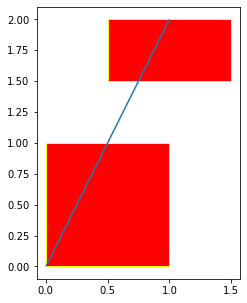

In [215]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
polys_gdf.plot(ax=ax,facecolor='r', edgecolor='yellow' )
lines_gdf.plot(ax=ax)
plt.show()

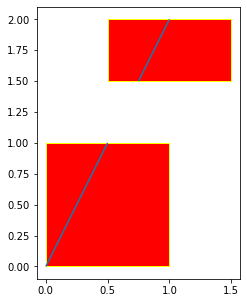

In [216]:
# boolean linestring with shapely
fig, ax = plt.subplots(1,1, figsize=(5,5))
polys_gdf.plot(ax=ax,facecolor='r', edgecolor='yellow' )
gpd.overlay(lines_gdf, polys_gdf, how='intersection').plot(ax=ax) 
plt.show()

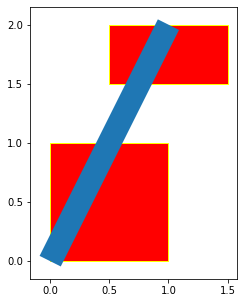

In [217]:
buffer_gdf = gpd.GeoDataFrame(geometry=lines_gdf.buffer(distance=0.1, cap_style=2))

fig, ax = plt.subplots(1,1, figsize=(5,5))
polys_gdf.plot(ax=ax,facecolor='r', edgecolor='yellow' )
buffer_gdf.plot(ax=ax)
plt.show()

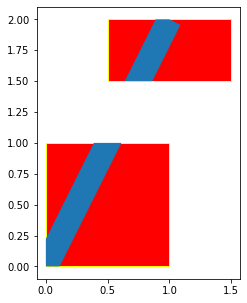

In [218]:
# boolean linestring buffer with shapely
fig, ax = plt.subplots(1,1, figsize=(5,5))
polys_gdf.plot(ax=ax,facecolor='r', edgecolor='yellow' )
gpd.overlay(buffer_gdf, polys_gdf, how='intersection').plot(ax=ax) 
plt.show()

<AxesSubplot:>

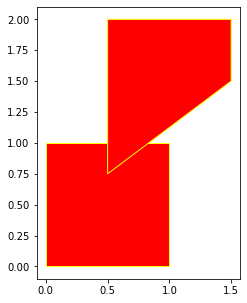

In [229]:
poly_list1 = [Polygon([[0, 0], [1, 0], [1, 1], [0, 1]]), Polygon([[0.5, 0.75], [1.5, 1.5], [1.5, 2], [0.5, 2]])]

polys_gdf1 = gpd.GeoDataFrame(geometry=poly_list1)
fig, ax = plt.subplots(1,1, figsize=(5,5))
polys_gdf1.plot(ax=ax,facecolor='r', edgecolor='yellow' )

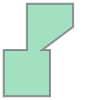

In [230]:
polys_gdf1.unary_union

#### Create road buffer using LION

In [231]:
Lion = gpd.read_file('./Data/Raw_Data/Geo/LION_21A/LION_21A.shp')
Lion.head()

,OBJECTID,Street,SAFStreetN,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,SpecAddr,FaceCode,SeqNum,StreetCode,SAFStreetC,LGC1,LGC2,LGC3,LGC4,LGC5,LGC6,LGC7,LGC8,LGC9,BOE_LGC,SegmentID,SegCount,LocStatus,LZip,RZip,LBoro,RBoro,L_CD,R_CD,LATOMICPOL,RATOMICPOL,LCT2010,LCT2010Suf,RCT2010,RCT2010Suf,LCB2010,LCB2010Suf,RCB2010,RCB2010Suf,LCT2000,LCT2000Suf,RCT2000,RCT2000Suf,LCB2000,LCB2000Suf,RCB2000,RCB2000Suf,LCT1990,LCT1990Suf,RCT1990,RCT1990Suf,LAssmDist,LElectDist,RAssmDist,RElectDist,SplitElect,LSchlDist,RSchlDist,SplitSchl,LSubSect,RSubSect,SanDistInd,MapFrom,MapTo,BoroBndry,MH_RI_Flag,XFrom,YFrom,XTo,YTo,ArcCenterX,ArcCenterY,CurveFlag,Radius,NodeIDFrom,NodeIDTo,NodeLevelF,NodeLevelT,ConParity,Twisted,RW_TYPE,PhysicalID,GenericID,NYPDID,FDNYID,LBlockFace,RBlockFace,LegacyID,Status,StreetWidt,StreetWi_1,StreetWi_2,BikeLane,BIKE_TRAFD,ACTIVE_FLA,POSTED_SPE,Snow_Prior,Number_Tra,Number_Par,Number_Tot,Carto_Disp,FCC,ROW_Type,LLo_Hyphen,LHi_Hyphen,RLo_Hyphen,RHi_Hyphen,FromLeft,ToLeft,FromRight,ToRight,Join_ID,L_PD_Servi,R_PD_Servi,TRUCK_ROUT,SHAPE_Leng,geometry
0,1.0,EAST 168 STREET,None,0,U,None,B,None,T,DOT,None,2510,03070,226700,None,01,None,None,None,None,None,None,None,None,1,0078126,1,X,10456,10456,2.0,2.0,203,203,402,101,149,None,185,None,3001,None,2000,None,149,None,137,None,4000,None,1000,None,149,None,137,None,79,040,79,040,None,09,09,None,1B,1B,None,3D,3D,None,None,1010964,241812,1011265,241555,0,0,None,0,0047740,9045677,M,M,None,None,1,35231.0,30694.0,None,None,1422600653,1422602017,0078126,2,34.0,34.0,None,None,None,None,25,S,2,2,4,None,None,None,599,699,596,716,599,699,596,716,2251001000000,None,None,None,396.030947,"LINESTRING (1010964.447 241812.261, 1011265.49..."
1,2.0,WEST 192 STREET,None,0,U,None,B,None,A,DOT,None,7984,00040,274810,None,01,None,None,None,None,None,None,None,None,1,0079796,1,None,10468,10468,2.0,2.0,207,207,302,104,265,None,265,None,2000,None,1004,None,265,None,265,None,3001,None,1003,None,265,None,265,None,78,045,78,059,None,10,10,None,1A,1A,None,3C,3C,None,None,1011577,255024,1011335,255164,0,0,None,0,0048679,0048678,M,M,None,None,1,35248.0,30711.0,None,None,1522607129,1522607721,0079796,2,30.0,30.0,None,None,None,None,25,S,1,2,3,None,None,None,58,98,63,99,58,98,63,99,2798401000000,None,None,None,279.360514,"LINESTRING (1011576.687 255023.583, 1011335.15..."
2,3.0,UNION AVENUE,None,0,U,None,B,None,W,DOT,None,7280,00130,270420,None,01,None,None,None,None,None,None,None,None,1,0077356,4,X,10459,10459,2.0,2.0,203,203,402,401,135,None,131,None,2000,None,3006,None,135,None,131,None,4000,None,4001,None,135,None,131,None,79,046,79,026,None,12,12,None,1A,1A,None,6C,6C,None,None,1011601,239640,1011786,240230,0,0,None,0,0047288,0047822,M,M,None,None,1,35252.0,30715.0,None,None,1422603726,1422604132,0077356,2,34.0,34.0,None,None,None,None,25,S,1,2,3,None,None,None,1017,1079,1016,1084,1017,1079,1016,1084,2728001000000,None,None,None,618.327133,"LINESTRING (1011600.676 239639.743, 1011785.79..."
3,4.0,UNION AVENUE,BEHAGEN PLAYGROUND COMFORT STA,0,U,None,B,None,W,DOT,X,7280,00130,270420,212795,01,None,None,None,None,None,None,None,None,1,0077356,4,X,10459,10459,2.0,2.0,203,203,402,401,135,None,131,None,2000,None,3006,None,135,None,131,None,4000,None,4001,None,135,None,131,None,79,046,79,026,None,12,12,None,1A,1A,None,6C,6C,None,None,1011601,239640,1011786,240230,0,0,None,0,0047288,0047822,M,M,None,None,1,35252.0,30715.0,None,None,1422603726,1422604132,0077356,2,34.0,34.0,None,None,None,None,25,S,1,2,3,None,None,None,None,None,None,None,0,0,0,0,21279502000000X,None,None,None,618.327133,"LINESTRING (1011600.676 239639.743, 1011785.79..."
4,5.0,UNION AVENUE,BEHAGEN PLAYGROUND FIELD NORTH,0,U,None,B,None,W,DOT,X,7280,00130,270420,212795,01,None,None,None,None,None,None,None,None,1,0077356,4,X,10459,10459,2.0,2.0,203,203,402,401,135,None,131,None,2000,None,3006,None,135,None,131,None,4000,None,4001,None,135,None,131,None,79,046,79,026,None,12,12,None,1A,1A,None,6C,6C,None,None,1011601,239640,

In [252]:
road = Lion[Lion['RW_TYPE'] == '1'] # keep only street road (no highway)
road = road[road['NonPed'] != 'V'] #filter out roads without sidewalks
road = road[road['StreetWidt'] > 0] # keep street width greater than 0
road = road.reset_index(drop=True)
road.head()

,OBJECTID,Street,SAFStreetN,FeatureTyp,SegmentTyp,IncExFlag,RB_Layer,NonPed,TrafDir,TrafSrc,SpecAddr,FaceCode,SeqNum,StreetCode,SAFStreetC,LGC1,LGC2,LGC3,LGC4,LGC5,LGC6,LGC7,LGC8,LGC9,BOE_LGC,SegmentID,SegCount,LocStatus,LZip,RZip,LBoro,RBoro,L_CD,R_CD,LATOMICPOL,RATOMICPOL,LCT2010,LCT2010Suf,RCT2010,RCT2010Suf,LCB2010,LCB2010Suf,RCB2010,RCB2010Suf,LCT2000,LCT2000Suf,RCT2000,RCT2000Suf,LCB2000,LCB2000Suf,RCB2000,RCB2000Suf,LCT1990,LCT1990Suf,RCT1990,RCT1990Suf,LAssmDist,LElectDist,RAssmDist,RElectDist,SplitElect,LSchlDist,RSchlDist,SplitSchl,LSubSect,RSubSect,SanDistInd,MapFrom,MapTo,BoroBndry,MH_RI_Flag,XFrom,YFrom,XTo,YTo,ArcCenterX,ArcCenterY,CurveFlag,Radius,NodeIDFrom,NodeIDTo,NodeLevelF,NodeLevelT,ConParity,Twisted,RW_TYPE,PhysicalID,GenericID,NYPDID,FDNYID,LBlockFace,RBlockFace,LegacyID,Status,StreetWidt,StreetWi_1,StreetWi_2,BikeLane,BIKE_TRAFD,ACTIVE_FLA,POSTED_SPE,Snow_Prior,Number_Tra,Number_Par,Number_Tot,Carto_Disp,FCC,ROW_Type,LLo_Hyphen,LHi_Hyphen,RLo_Hyphen,RHi_Hyphen,FromLeft,ToLeft,FromRight,ToRight,Join_ID,L_PD_Servi,R_PD_Servi,TRUCK_ROUT,SHAPE_Leng,geometry
0,1.0,EAST 168 STREET,None,0,U,None,B,None,T,DOT,None,2510,03070,226700,None,01,None,None,None,None,None,None,None,None,1,0078126,1,X,10456,10456,2.0,2.0,203,203,402,101,149,None,185,None,3001,None,2000,None,149,None,137,None,4000,None,1000,None,149,None,137,None,79,040,79,040,None,09,09,None,1B,1B,None,3D,3D,None,None,1010964,241812,1011265,241555,0,0,None,0,0047740,9045677,M,M,None,None,1,35231.0,30694.0,None,None,1422600653,1422602017,0078126,2,34.0,34.0,None,None,None,None,25,S,2,2,4,None,None,None,599,699,596,716,599,699,596,716,2251001000000,None,None,None,396.030947,"LINESTRING (1010964.447 241812.261, 1011265.49..."
1,2.0,WEST 192 STREET,None,0,U,None,B,None,A,DOT,None,7984,00040,274810,None,01,None,None,None,None,None,None,None,None,1,0079796,1,None,10468,10468,2.0,2.0,207,207,302,104,265,None,265,None,2000,None,1004,None,265,None,265,None,3001,None,1003,None,265,None,265,None,78,045,78,059,None,10,10,None,1A,1A,None,3C,3C,None,None,1011577,255024,1011335,255164,0,0,None,0,0048679,0048678,M,M,None,None,1,35248.0,30711.0,None,None,1522607129,1522607721,0079796,2,30.0,30.0,None,None,None,None,25,S,1,2,3,None,None,None,58,98,63,99,58,98,63,99,2798401000000,None,None,None,279.360514,"LINESTRING (1011576.687 255023.583, 1011335.15..."
2,3.0,UNION AVENUE,None,0,U,None,B,None,W,DOT,None,7280,00130,270420,None,01,None,None,None,None,None,None,None,None,1,0077356,4,X,10459,10459,2.0,2.0,203,203,402,401,135,None,131,None,2000,None,3006,None,135,None,131,None,4000,None,4001,None,135,None,131,None,79,046,79,026,None,12,12,None,1A,1A,None,6C,6C,None,None,1011601,239640,1011786,240230,0,0,None,0,0047288,0047822,M,M,None,None,1,35252.0,30715.0,None,None,1422603726,1422604132,0077356,2,34.0,34.0,None,None,None,None,25,S,1,2,3,None,None,None,1017,1079,1016,1084,1017,1079,1016,1084,2728001000000,None,None,None,618.327133,"LINESTRING (1011600.676 239639.743, 1011785.79..."
3,4.0,UNION AVENUE,BEHAGEN PLAYGROUND COMFORT STA,0,U,None,B,None,W,DOT,X,7280,00130,270420,212795,01,None,None,None,None,None,None,None,None,1,0077356,4,X,10459,10459,2.0,2.0,203,203,402,401,135,None,131,None,2000,None,3006,None,135,None,131,None,4000,None,4001,None,135,None,131,None,79,046,79,026,None,12,12,None,1A,1A,None,6C,6C,None,None,1011601,239640,1011786,240230,0,0,None,0,0047288,0047822,M,M,None,None,1,35252.0,30715.0,None,None,1422603726,1422604132,0077356,2,34.0,34.0,None,None,None,None,25,S,1,2,3,None,None,None,None,None,None,None,0,0,0,0,21279502000000X,None,None,None,618.327133,"LINESTRING (1011600.676 239639.743, 1011785.79..."
4,5.0,UNION AVENUE,BEHAGEN PLAYGROUND FIELD NORTH,0,U,None,B,None,W,DOT,X,7280,00130,270420,212795,01,None,None,None,None,None,None,None,None,1,0077356,4,X,10459,10459,2.0,2.0,203,203,402,401,135,None,131,None,2000,None,3006,None,135,None,131,None,4000,None,4001,None,135,None,131,None,79,046,79,026,None,12,12,None,1A,1A,None,6C,6C,None,None,1011601,239640,

In [253]:
road.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [260]:
road_Buffer = pd.DataFrame()
for i,j in enumerate(road['StreetWidt']):
    road_Buffer = road_Buffer.append(pd.DataFrame(road.loc[[i]]['geometry'].buffer(distance=j/2)))

In [261]:
road_Buffer = gpd.GeoDataFrame(geometry=road_Buffer[0], crs=2263)
road_Buffer.head()

,geometry
0,"POLYGON ((1011276.540 241567.870, 1011277.754 ..."
1,"POLYGON ((1011327.618 255150.988, 1011326.383 ..."
2,"POLYGON ((1011769.574 240234.798, 1011770.151 ..."
3,"POLYGON ((1011769.574 240234.798, 1011770.151 ..."
4,"POLYGON ((1011769.574 240234.798, 1011770.151 ..."


In [262]:
merge = road_Buffer.geometry.unary_union #Merge all roads into multipolygons
polys = [poly for poly in merge]
road_poly = gpd.GeoDataFrame(geometry=polys, crs=2263)
road_poly.head()

,geometry
0,"POLYGON ((916069.897 121088.912, 916069.320 12..."
1,"POLYGON ((1004121.409 140401.167, 1004121.960 ..."
2,"POLYGON ((1015982.145 145827.904, 1015982.279 ..."
3,"POLYGON ((1015846.832 146005.426, 1015847.315 ..."
4,"POLYGON ((984884.177 147511.274, 984884.498 14..."


In [263]:
# save this geo file
road_poly.to_file('./Data/Processed_Data/road_poly.geojson', driver='GeoJSON')

In [269]:
# load census tract data
ct2010 = gpd.read_file('./Data/Processed_Data/ct2010_geoid.geojson').to_crs(2263)
ct2010.head()

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,GeoID,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,36085000900,"POLYGON ((962269.126 173705.500, 962288.722 17..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.200308,36061009800,"POLYGON ((994133.507 214848.898, 994005.909 21..."
2,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,36061010200,"POLYGON ((992216.539 216507.687, 992091.031 21..."
3,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,36061010400,"POLYGON ((991325.882 217001.689, 991199.221 21..."
4,1,1011300,Manhattan,I,011300,113,MN17,Midtown-Midtown South,3807,1.890907e+06,5699.860640,36061011300,"POLYGON ((988650.277 214286.402, 988517.806 21..."


In [270]:
# Boolean operations 
ct_road = gpd.overlay(road_poly, ct2010, how='intersection')

In [282]:
ct_road['road_area'] = ct_road.area
ct_road = ct_road.groupby('GeoID').agg({'road_area':'sum'})
ct_road.head()

,road_area
GeoID,
36005000100,1.566373e+06
36005000200,7.869340e+05
36005000400,1.172759e+06
36005001600,9.659733e+05
36005001900,2.085712e+06


In [283]:
ct_road

,road_area
GeoID,
36005000100,1.566373e+06
36005000200,7.869340e+05
36005000400,1.172759e+06
36005001600,9.659733e+05
36005001900,2.085712e+06
...,...
36085030301,1.358868e+06
36085030302,1.316955e+06
36085031901,6.127782e+05


#### sidewalk area

In [286]:
sidewalk = gpd.read_file('./Data/Raw_Data/Geo/Sidewalk/geo_export_4545b2ef-102b-4fd5-aacd-c0b896e7881c.shp').to_crs(2263)
sidewalk.head()

,feat_code,shape_area,shape_leng,source_id,status,sub_code,geometry
0,3800.0,12252.910554,1763.887092,2.138000e+10,Unchanged,380000.0,"POLYGON ((984808.223 190837.194, 984802.411 19..."
1,3800.0,5784.683784,1004.777693,2.138000e+10,Unchanged,380000.0,"POLYGON ((985043.926 190997.138, 985062.305 19..."
2,3800.0,2662.091456,828.312364,2.138000e+10,Unchanged,380000.0,"POLYGON ((989755.070 195457.325, 989753.092 19..."
3,3800.0,77.343809,38.361842,2.138000e+10,Unchanged,380000.0,"POLYGON ((986680.772 193019.650, 986680.769 19..."
4,3800.0,31976.407120,5063.776578,2.138000e+10,Updated,380000.0,"POLYGON ((989716.779 194185.507, 989795.408 19..."


In [287]:
# Boolean operations 
ct_side = gpd.overlay(sidewalk, ct2010, how='intersection')

In [290]:
ct_side['walk_area'] = ct_side.area
ct_side = ct_side.groupby('GeoID').agg({'walk_area':'sum'})
ct_side.head()

,walk_area
GeoID,
36005000100,9.855936e+04
36005000200,2.916085e+05
36005000400,5.014021e+05
36005001600,4.746538e+05
36005001900,1.021118e+06


In [334]:
# merge
BE_WalkVSDrive = pd.merge(ct_road,ct_side, left_index=True, right_index=True)

In [340]:
BE_WalkVSDrive['BE_WalkVSDrive'] = BE_WalkVSDrive['walk_area']/BE_WalkVSDrive.sum(axis=1)
BE_WalkVSDrive = BE_WalkVSDrive[['BE_WalkVSDrive']]
BE_WalkVSDrive.head()

,BE_WalkVSDrive
GeoID,
36005000100,0.059197
36005000200,0.270373
36005000400,0.299495
36005001600,0.329477
36005001900,0.328669


In [342]:
BE_WalkVSDrive.describe()

,BE_WalkVSDrive
count,2162.000000
mean,0.367434
std,0.066568
min,0.059197
25%,0.330679
50%,0.361569
75%,0.395813
max,0.855943


In [343]:
# save this geo file
BE_WalkVSDrive.to_csv('./Data/Processed_Data/BE_WalkVSDrive.csv')

### BE_Transit:  
**Description:** Numbers of Transits(train, subway, bus, or ferry stop.) within 15 min walk distance (0.8 mile)

**Method:** Calculate the number of Transits within 0.8 miles of the census block's centroid, then average the census block values that correspond to the census tract .

**Data Source:** OpenStreetMap(OSM) via osmnx library

**Geography:** Point/census block/census tract

**Date:** 2022

In [31]:
place = 'New York, USA'
tags = {'public_transport':'stop_position'} 
transit = ox.geometries_from_place(place, tags=tags)
transit = transit[transit.geom_type == 'Point'].reset_index()[['public_transport','geometry']]
transit = transit.to_crs(2263)
transit.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [32]:
cb2010_Buffer = gpd.read_file('./Data/Processed_Data/cb2010_Buffer.geojson')
cb2010_Buffer.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [33]:
# spatial join with cb2010_Buffer
BE_Transit = gpd.sjoin(transit, cb2010_Buffer, how="right", op='intersects')
BE_Transit = BE_Transit.groupby('BCTCB2010').agg({'public_transport':'count','GeoID':'mean'})
BE_Transit['GeoID'] = BE_Transit['GeoID'].astype('int')
BE_Transit = BE_Transit.groupby('GeoID').agg({'public_transport':'mean'}).reset_index().rename(columns={'public_transport':'BE_Transit'})
BE_Transit.head()

/Users/taoliang/opt/anaconda3/envs/ADS/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


,GeoID,BE_Transit
0,36005000100,2.000000
1,36005000200,4.478261
2,36005000400,3.358974
3,36005001600,9.700000
4,36005001900,19.677419


In [34]:
BE_Transit.describe()

,GeoID,BE_Transit
count,2.165000e+03,2165.000000
mean,3.605475e+10,29.470933
std,2.595373e+07,29.162324
min,3.600500e+10,0.000000
25%,3.604703e+10,11.925000
50%,3.604712e+10,20.538462
75%,3.608103e+10,36.571429
max,3.608599e+10,204.375000


In [35]:
# save file
BE_Transit.to_csv("./Data/Processed_Data/BE_Transit.csv")

### BE_Park:  
**Description:** Area(arce) of parks within 15 min walk distance (0.8 mile)

**Method:** Calculate the total area of parks within 0.8 miles of the census block's centroid, then average the census block values that correspond to the census tract .

**Data Source:** OpenStreetMap(OSM) via osmnx library

**Geography:** Polygon/census block/census tract

**Date:** 2022

In [36]:
place = 'New York, USA'
tags = {'leisure':'park'} 
park = ox.geometries_from_place(place, tags=tags)
park.head()

highway                    geometry barrier  \
element_type osmid                                                   
node         357545993     NaN  POINT (-73.91403 40.87316)     NaN   
             357554167     NaN  POINT (-73.91097 40.71094)     NaN   
             357558856     NaN  POINT (-73.91014 40.88177)     NaN   
             357562455     NaN  POINT (-74.12625 40.54816)     NaN   
             357563150     NaN  POINT (-73.83958 40.87343)     NaN   

                                         name operator man_made ele  \
element_type osmid                                                    
node         357545993            Baker Field      NaN      NaN  17   
             357554167  Grover Cleveland Park      NaN      NaN  31   
             357558856              Ewen Park      NaN      NaN  21   
             357562455       Great Kills Park      NaN      NaN   6   
             357563150            Haffen Park      NaN      NaN  15   

                       gnis:county_id gnis:created gnis:feature_id  \
element_type osmid                                                   
node         357545993            061   01/23/1980          942830   
             357554167            081   01/23/1980          946857   
             357558856            005   01/23/1980          949783   
             357562455            085   01/23/1980          951634   
             357563150            005   01/23/1980          951981   

                       gnis:state_id leisure   wikidata gnis:edited heritage  \
element_type osmid                                                             
node         357545993            36    park  Q34804359         NaN      NaN   
             357554167            36    park        NaN  01/17/2008      NaN   
             357558856            36    park        NaN         NaN      NaN   
             357562455            36    park        NaN         NaN      NaN   
             357563150            36    park        NaN         NaN      NaN   

                       heritage:operator heritage:website historic  \
element_type osmid                                                   
node         357545993               NaN              NaN      NaN   
             357554167               NaN              NaN      NaN   
             357558856               NaN              NaN      NaN   
             357562455               NaN              NaN      NaN   
             357563150               NaN              NaN      NaN   

                       nrhp:criteria nrhp:inscription_date ref:nrhp  \
element_type osmid                                                    
node         357545993           NaN                   NaN      NaN   
             357554167           NaN                   NaN      NaN   
             357558856           NaN                   NaN      NaN   
             357562455           NaN                   NaN      NaN   
             357563150           NaN                   NaN      NaN   

                       source_ref opening_hours website start_date wikipedia  \
element_type osmid                                                             
node         357545993        NaN           NaN     NaN        NaN       NaN   
             357554167        NaN           NaN     NaN        NaN       NaN   
             357558856        NaN           NaN     NaN        NaN       NaN   
             357562455        NaN           NaN     NaN        NaN       NaN   
             357563150        NaN           NaN     NaN        NaN       NaN   

                       operator:type operator:wikidata operator:wikipedia  \
element_type osmid                                                          
node         357545993           NaN               NaN                NaN   
             357554167           NaN               NaN                NaN   
             357558856           NaN               NaN                NaN   
             357562455           NaN           

In [62]:
park = park[(park.geom_type == 'Polygon')|(park.geom_type == 'MultiPolygon')].reset_index()[['name','geometry']].to_crs(2263)
park

,name,geometry
0,Battery Park,"POLYGON ((979507.536 196051.889, 979502.458 19..."
1,Cadman Plaza Park,"POLYGON ((986982.303 193027.461, 987064.827 19..."
2,Fort Greene Park,"POLYGON ((991374.296 191816.446, 991373.148 19..."
3,Columbus Park,"POLYGON ((986956.240 191999.575, 986865.283 19..."
4,Korean War Veterans Plaza,"POLYGON ((986947.547 192877.171, 986960.941 19..."
...,...,...
1662,Long Pond Park,"MULTIPOLYGON (((919705.031 127667.166, 919700...."
1663,Bella Abzug Park,"MULTIPOLYGON (((983788.791 214303.804, 983894...."
1664,McCarren Park,"MULTIPOLYGON (((996739.322 202425.356, 997064...."
1665,Red Hook Park,"MULTIPOLYGON (((983030.064 184685.623, 983482...."


In [63]:
park.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [76]:
# boolean operation
BE_Park = gpd.overlay(cb2010_Buffer, park, how='intersection')

In [77]:
BE_Park['BE_Park'] = BE_Park.area/43560 # 1 acre equals 43560 square feet
BE_Park.head()

,GeoID,BCTCB2010,name,geometry,BE_Park
0,36085000900,50009001000,Nicholas Lia Memorial Park,"POLYGON ((962121.696 173913.124, 962200.943 17...",1.305141
1,36085007500,50075001000,Nicholas Lia Memorial Park,"POLYGON ((962121.696 173913.124, 962200.943 17...",1.305141
2,36085007700,50077001000,Nicholas Lia Memorial Park,"POLYGON ((962121.696 173913.124, 962200.943 17...",1.305141
3,36085000900,50009001001,Nicholas Lia Memorial Park,"POLYGON ((962121.696 173913.124, 962200.943 17...",1.305141
4,36085001100,50011001001,Nicholas Lia Memorial Park,"POLYGON ((962121.696 173913.124, 962200.943 17...",1.305141


In [78]:
BE_Park = BE_Park.groupby('BCTCB2010').agg({'BE_Park':'sum','GeoID':'mean'})
BE_Park['GeoID'] = BE_Park['GeoID'].astype('int')
BE_Park.head()

,BE_Park,GeoID
BCTCB2010,,
10001001000,41.675515,36061000100
10001001001,41.572781,36061000100
10002011000,92.115029,36061000201
10002011001,90.548518,36061000201
10002012000,89.156724,36061000201


In [79]:
BE_Park = BE_Park.groupby('GeoID').agg({'BE_Park':'mean'}).reset_index()
BE_Park.head()

,GeoID,BE_Park
0,36005000100,3.607041
1,36005000200,117.919240
2,36005000400,81.596888
3,36005001600,142.340526
4,36005001900,149.885542


In [80]:
BE_Park.describe()

,GeoID,BE_Park
count,2.165000e+03,2165.000000
mean,3.605475e+10,98.125953
std,2.595373e+07,108.549134
min,3.600500e+10,0.977895
25%,3.604703e+10,23.685854
50%,3.604712e+10,54.780130
75%,3.608103e+10,134.545455
max,3.608599e+10,797.281378


In [81]:
# save file
BE_Park.to_csv("./Data/Processed_Data/BE_Park.csv")

### Merge Data

In [63]:
BE_TreeD = pd.read_csv('./Data/Processed_Data/BE_TreeD.csv', index_col=0)
BE_LandMIX = pd.read_csv("./Data/Processed_Data/BE_LandMIX.csv")
BE_nodeD = pd.read_csv("./Data/Processed_Data/BE_nodeD.csv", index_col=0)
BE_JFood = pd.read_csv("./Data/Processed_Data/BE_JFood.csv", index_col=0)
BE_HFood = pd.read_csv("./Data/Processed_Data/BE_HFood.csv", index_col=0)
BE_WalkVSDrive = pd.read_csv('./Data/Processed_Data/BE_WalkVSDrive.csv')
BE_Transit = pd.read_csv("./Data/Processed_Data/BE_Transit.csv", index_col=0)
BE_Park = pd.read_csv("./Data/Processed_Data/BE_Park.csv", index_col=0)

In [72]:
from functools import reduce
dfs = [BE_TreeD, BE_LandMIX, BE_nodeD, BE_JFood, BE_HFood, BE_WalkVSDrive, BE_Transit, BE_Park]
Built_Environment  = reduce(lambda left,right: pd.merge(left,right, on='GeoID', how='outer'), dfs)

In [73]:
Built_Environment

,BE_TreeD,GeoID,BE_LandMIX,BE_nodeD,BE_JFood,BE_HFood,BE_WalkVSDrive,BE_Transit,BE_Park
0,3.277940,36005000200,0.001968,2.234613,0.478261,0.000000,0.270373,4.478261,117.919240
1,2.315981,36005000400,0.004807,1.827311,0.487179,0.000000,0.299495,3.358974,81.596888
2,4.363233,36005001600,0.003290,1.993906,5.500000,1.000000,0.329477,9.700000,142.340526
3,1.229604,36005001900,0.000547,0.519004,4.677419,1.107527,0.328669,19.677419,149.885542
4,4.238579,36005002000,0.000000,3.595761,7.722222,1.055556,0.427229,11.166667,206.998551
...,...,...,...,...,...,...,...,...,...
2160,NaN,36061024000,0.000000,0.885436,4.272727,1.545455,0.303717,11.545455,248.817602
2161,NaN,36081091602,0.000000,0.337084,1.705882,0.088235,0.159136,2.558824,450.659674
2162,NaN,36081099900,0.000000,1.380231,0.000000,0.000000,0.273985,3.081081,75.364746
2163,NaN,36085015400,0.000000,NaN,0.000000,0.000000,0.499199,0.000000,443.189485


In [80]:
Built_Environment = Built_Environment.fillna(0)

In [81]:
# save file
Built_Environment.to_csv("./Data/Processed_Data/Domain/Built_Environment.csv")